In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Grid visualization (2=robot, 1=neighbor, 0=other):
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 0 0]
 [0 0 0 1 2 1 0 0]
 [0 0 0 1 1 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


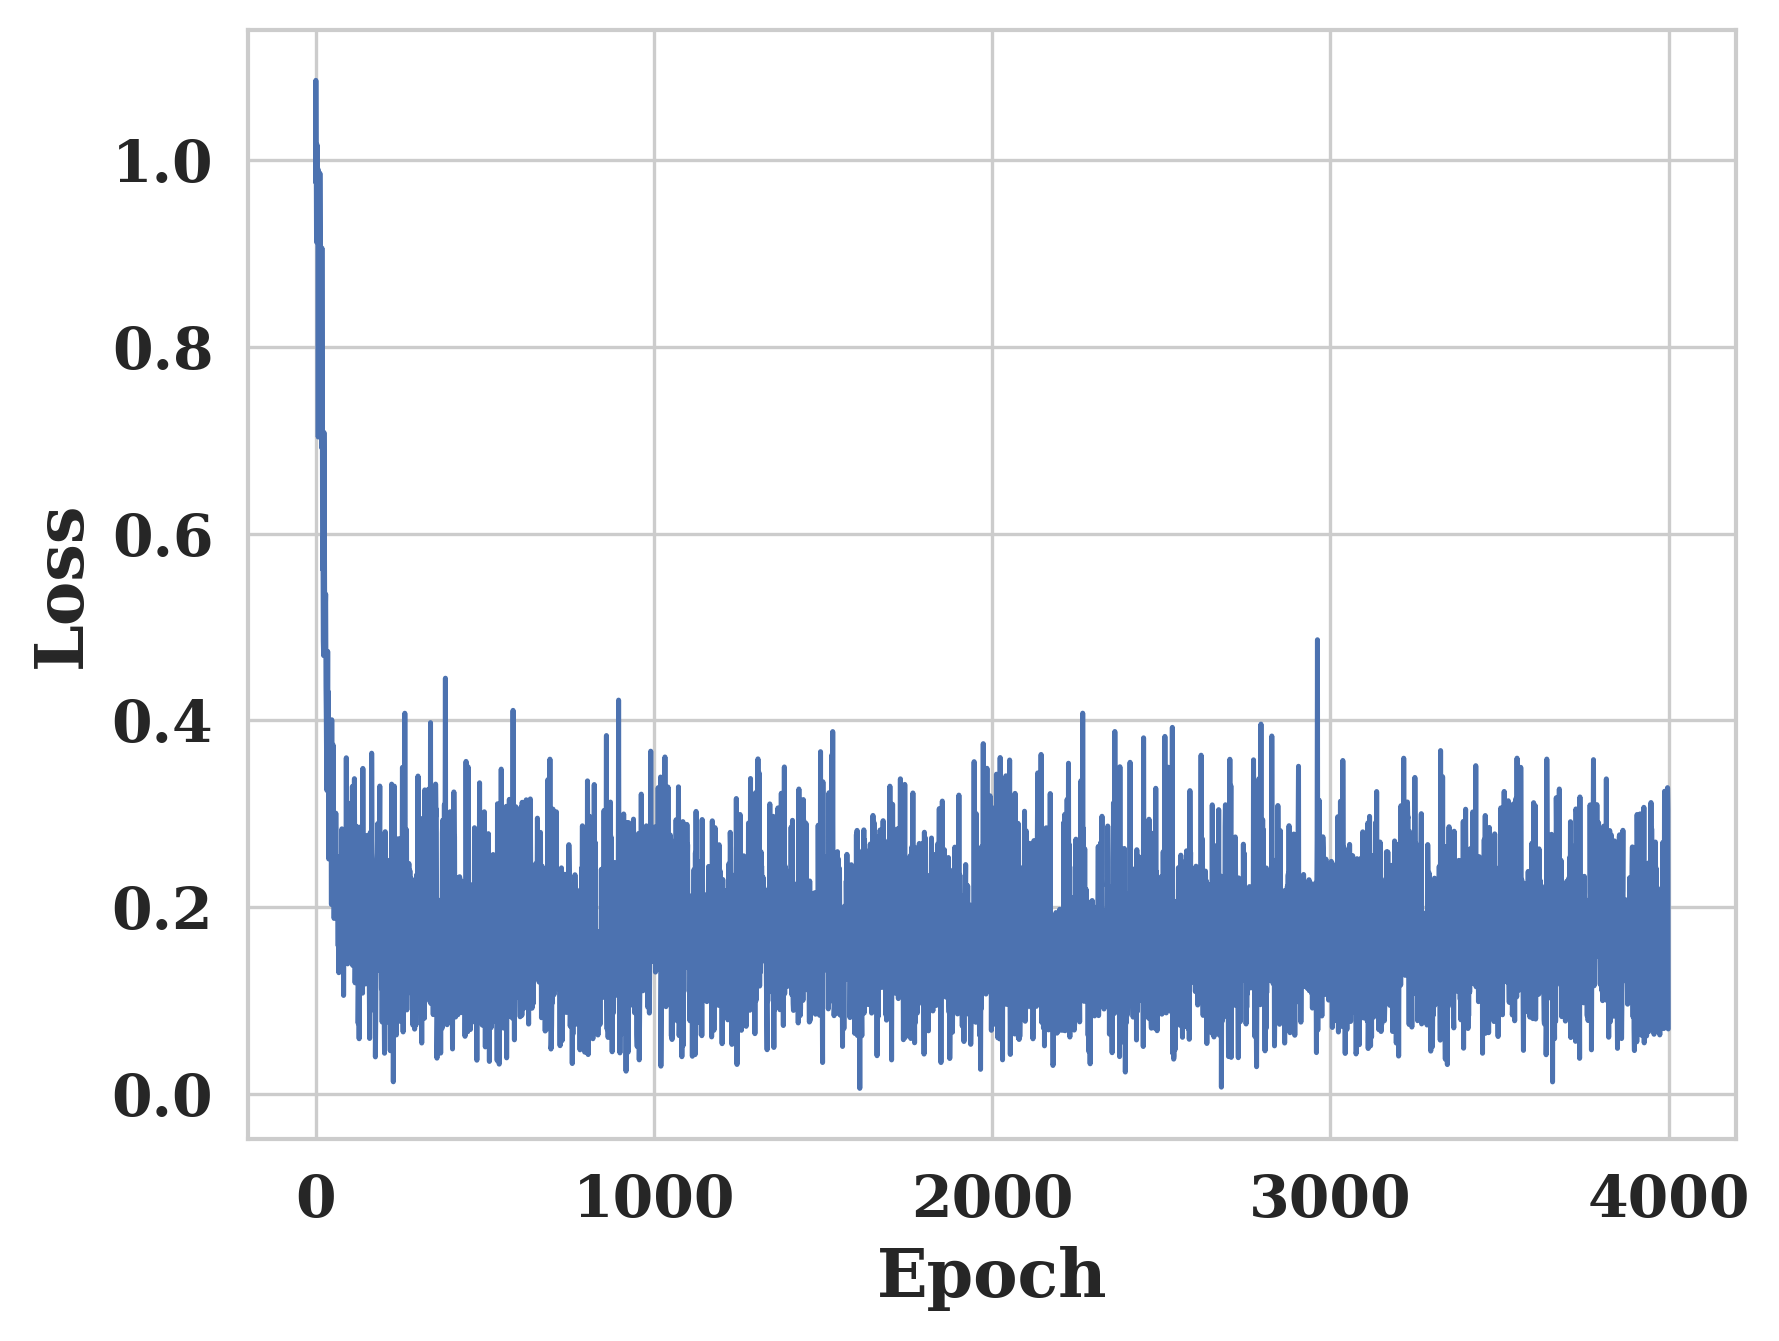

In [79]:
# BYOL for learning robot idx embeddings
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class IntegerEmbeddingModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(IntegerEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, embedding_dim)
        self.linear2 = nn.Linear(embedding_dim, embedding_dim) 

    def forward(self, x):
        x = self.embedding(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return x

def contrastive_loss(embedding1, embedding2):
    # Simple contrastive loss that encourages the model to make embeddings similar
    # You might want to experiment with more sophisticated losses
    return ((embedding1 - embedding2)**2).mean()
def get_hexagonal_neighbors(index, grid_size=8):
    """
    Get indices of neighboring robots in a hexagonal grid.
    For even rows: neighbors are at top-left, top-right, left, right, bottom-left, bottom-right
    For odd rows: neighbors are at top-left, top-right, left, right, bottom-left, bottom-right
    """
    row, col = index // grid_size, index % grid_size
    neighbors = []
    
    # Check if we're on an even or odd row
    is_even_row = (row % 2 == 0)
    
    # Neighbor offsets for even and odd rows
    # Format: (row_offset, col_offset)
    if is_even_row:
        directions = [
            (-1, -1),  # top-left
            (-1, 0),   # top-right
            (0, -1),   # left
            (0, 1),    # right
            (1, -1),   # bottom-left
            (1, 0),    # bottom-right
        ]
    else:
        directions = [
            (-1, 0),   # top-left
            (-1, 1),   # top-right
            (0, -1),   # left
            (0, 1),    # right
            (1, 0),    # bottom-left
            (1, 1),    # bottom-right
        ]
    
    # Check each potential neighbor
    for row_offset, col_offset in directions:
        new_row = row + row_offset
        new_col = col + col_offset
        
        # Check if the neighbor is within grid bounds
        if (0 <= new_row < grid_size and 
            0 <= new_col < grid_size):
            neighbor_index = new_row * grid_size + new_col
            neighbors.append(neighbor_index)
    
    return np.array(neighbors)
def visualize_neighbors(index, grid_size=8):
    """
    Helper function to visualize the neighbors of a given robot
    """
    grid = np.zeros((grid_size, grid_size), dtype=int)
    row, col = index // grid_size, index % grid_size
    
    # Mark center robot
    grid[row, col] = 2
    
    # Mark neighbors
    neighbors = get_neighbors(index, grid_size)
    for n in neighbors:
        n_row, n_col = n // grid_size, n % grid_size
        grid[n_row, n_col] = 1
    
    return grid

# Test the function
# Example for a robot in the middle of the grid
test_index = 28  # Example index
grid = visualize_neighbors(test_index)

# Print the grid (2 is the robot, 1s are neighbors, 0s are other positions)
print("Grid visualization (2=robot, 1=neighbor, 0=other):")
print(grid)
def get_neighbors(index, grid_size=8):
    # Convert linear index to row and col
    row, col = index // grid_size, index % grid_size
    if row % 2 == 0:
        neighbor_coords = [
            (row-1, col),    # up
            (row+1, col),    # down
            (row, col-1),    # left
            (row, col+1),    # right
            (row-1, col-1),  # up-left
            (row+1, col-1),   # down-left
            (row-1, col+1),  # up-left
            (row+1, col+1)   # down-left
        ]
    else:
        neighbor_coords = [
            (row-1, col),    # up
            (row+1, col),    # down
            (row, col-1),    # left
            (row, col+1),    # right
            (row-1, col+1),  # up-right
            (row+1, col+1),   # down-right
            (row-1, col-1),  # up-left
            (row+1, col-1)   # down-left
        ]

    # Filter out neighbors that are outside the grid
    valid_neighbors = []
    for r, c in neighbor_coords:
        if 0 <= r < grid_size and 0 <= c < grid_size:
            valid_neighbors.append(r * grid_size + c)
    
    return np.array(valid_neighbors)

def select_random_neighbors(batch_indices, neighbors):
    batch_size = len(batch_indices)
    random_neighbors = np.zeros(batch_size, dtype=int)
    for i in range(batch_size):
        neighbor_list = neighbors[batch_indices[i]]
        random_neighbors[i] = np.random.choice(neighbor_list)
    return random_neighbors

indices = np.arange(64)
neighbors = np.array([get_neighbors(i) for i in indices], dtype=object)
# print(neighbors)
# Model parameters
num_embeddings = 64  # For integers 0-63
embedding_dim = 128  # Size of the embedding vector
batch_size = 64

# Model, optimizer, and loss function
model = IntegerEmbeddingModel(num_embeddings, embedding_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
triplet_loss = nn.TripletMarginLoss(margin=1, p=2, eps=1e-6)
cos = nn.CosineSimilarity(dim=1)

# Training loop
num_epochs = 4000
grid_size = 8
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    idxs = np.random.randint(0, num_embeddings, (batch_size,))

    indices = torch.tensor(idxs).to(device)
    embedding1 = model(indices)
    random_neighbors = torch.tensor(select_random_neighbors(idxs, neighbors)).to(device)
    embedding2 = model(random_neighbors)

    indices_2 = (indices + torch.randint(0, num_embeddings, (batch_size,)).to(device)) % num_embeddings  # Ensure it wraps around at the max integer
    embedding3 = model(indices_2.to(device))

    # Compute the loss and update the model
    # loss = contrastive_loss(embedding1, embedding2)
    loss = triplet_loss(embedding1, embedding2, embedding3)
    # print(1 + cos(embedding1, embedding2) - cos(embedding1, embedding3))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [80]:
# load toech model
# model.load_state_dict(torch.load('idx_embedding_128.pth', weights_only=True))

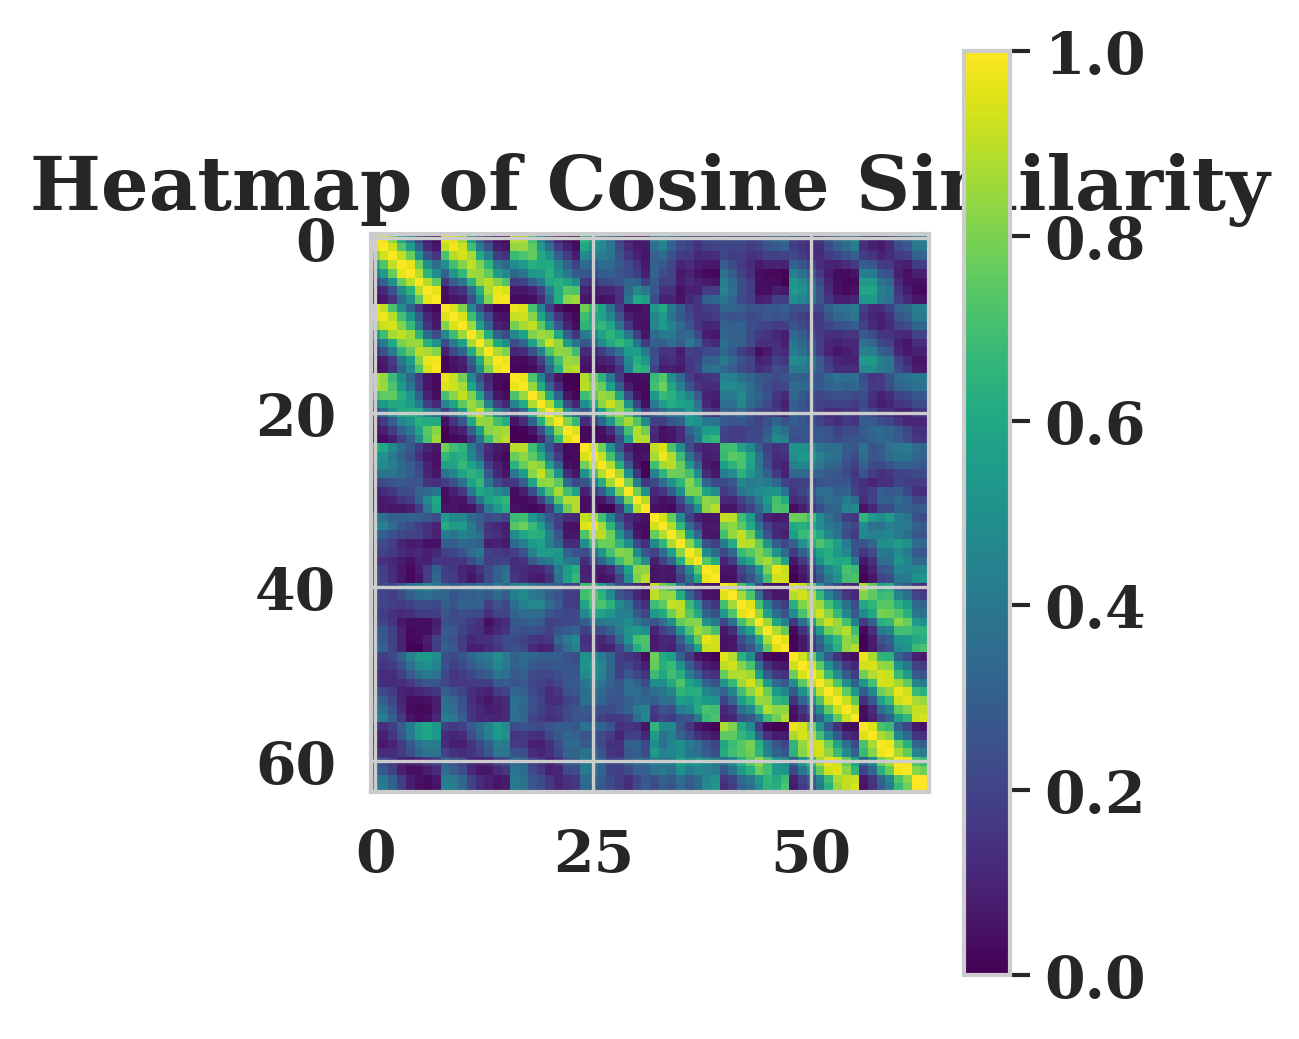

In [81]:
n_values = torch.arange(64).to(device)
a = model(n_values)
b = model(n_values)
cos_sim = torch.nn.CosineSimilarity(dim=0)

cos_sim_matrix = torch.zeros(64, 64)

for i in range(64):
    for j in range(64):
        cos_sim_matrix[i, j] = cos_sim(a[i], b[j])


# Plotting the heatmap
plt.figure(figsize=(3, 4))
plt.title("Heatmap of Cosine Similarity")
plt.imshow(cos_sim_matrix.detach().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

/tmp/ipykernel_2008557/4203625862.py:52: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  hexagon = RegularPolygon(


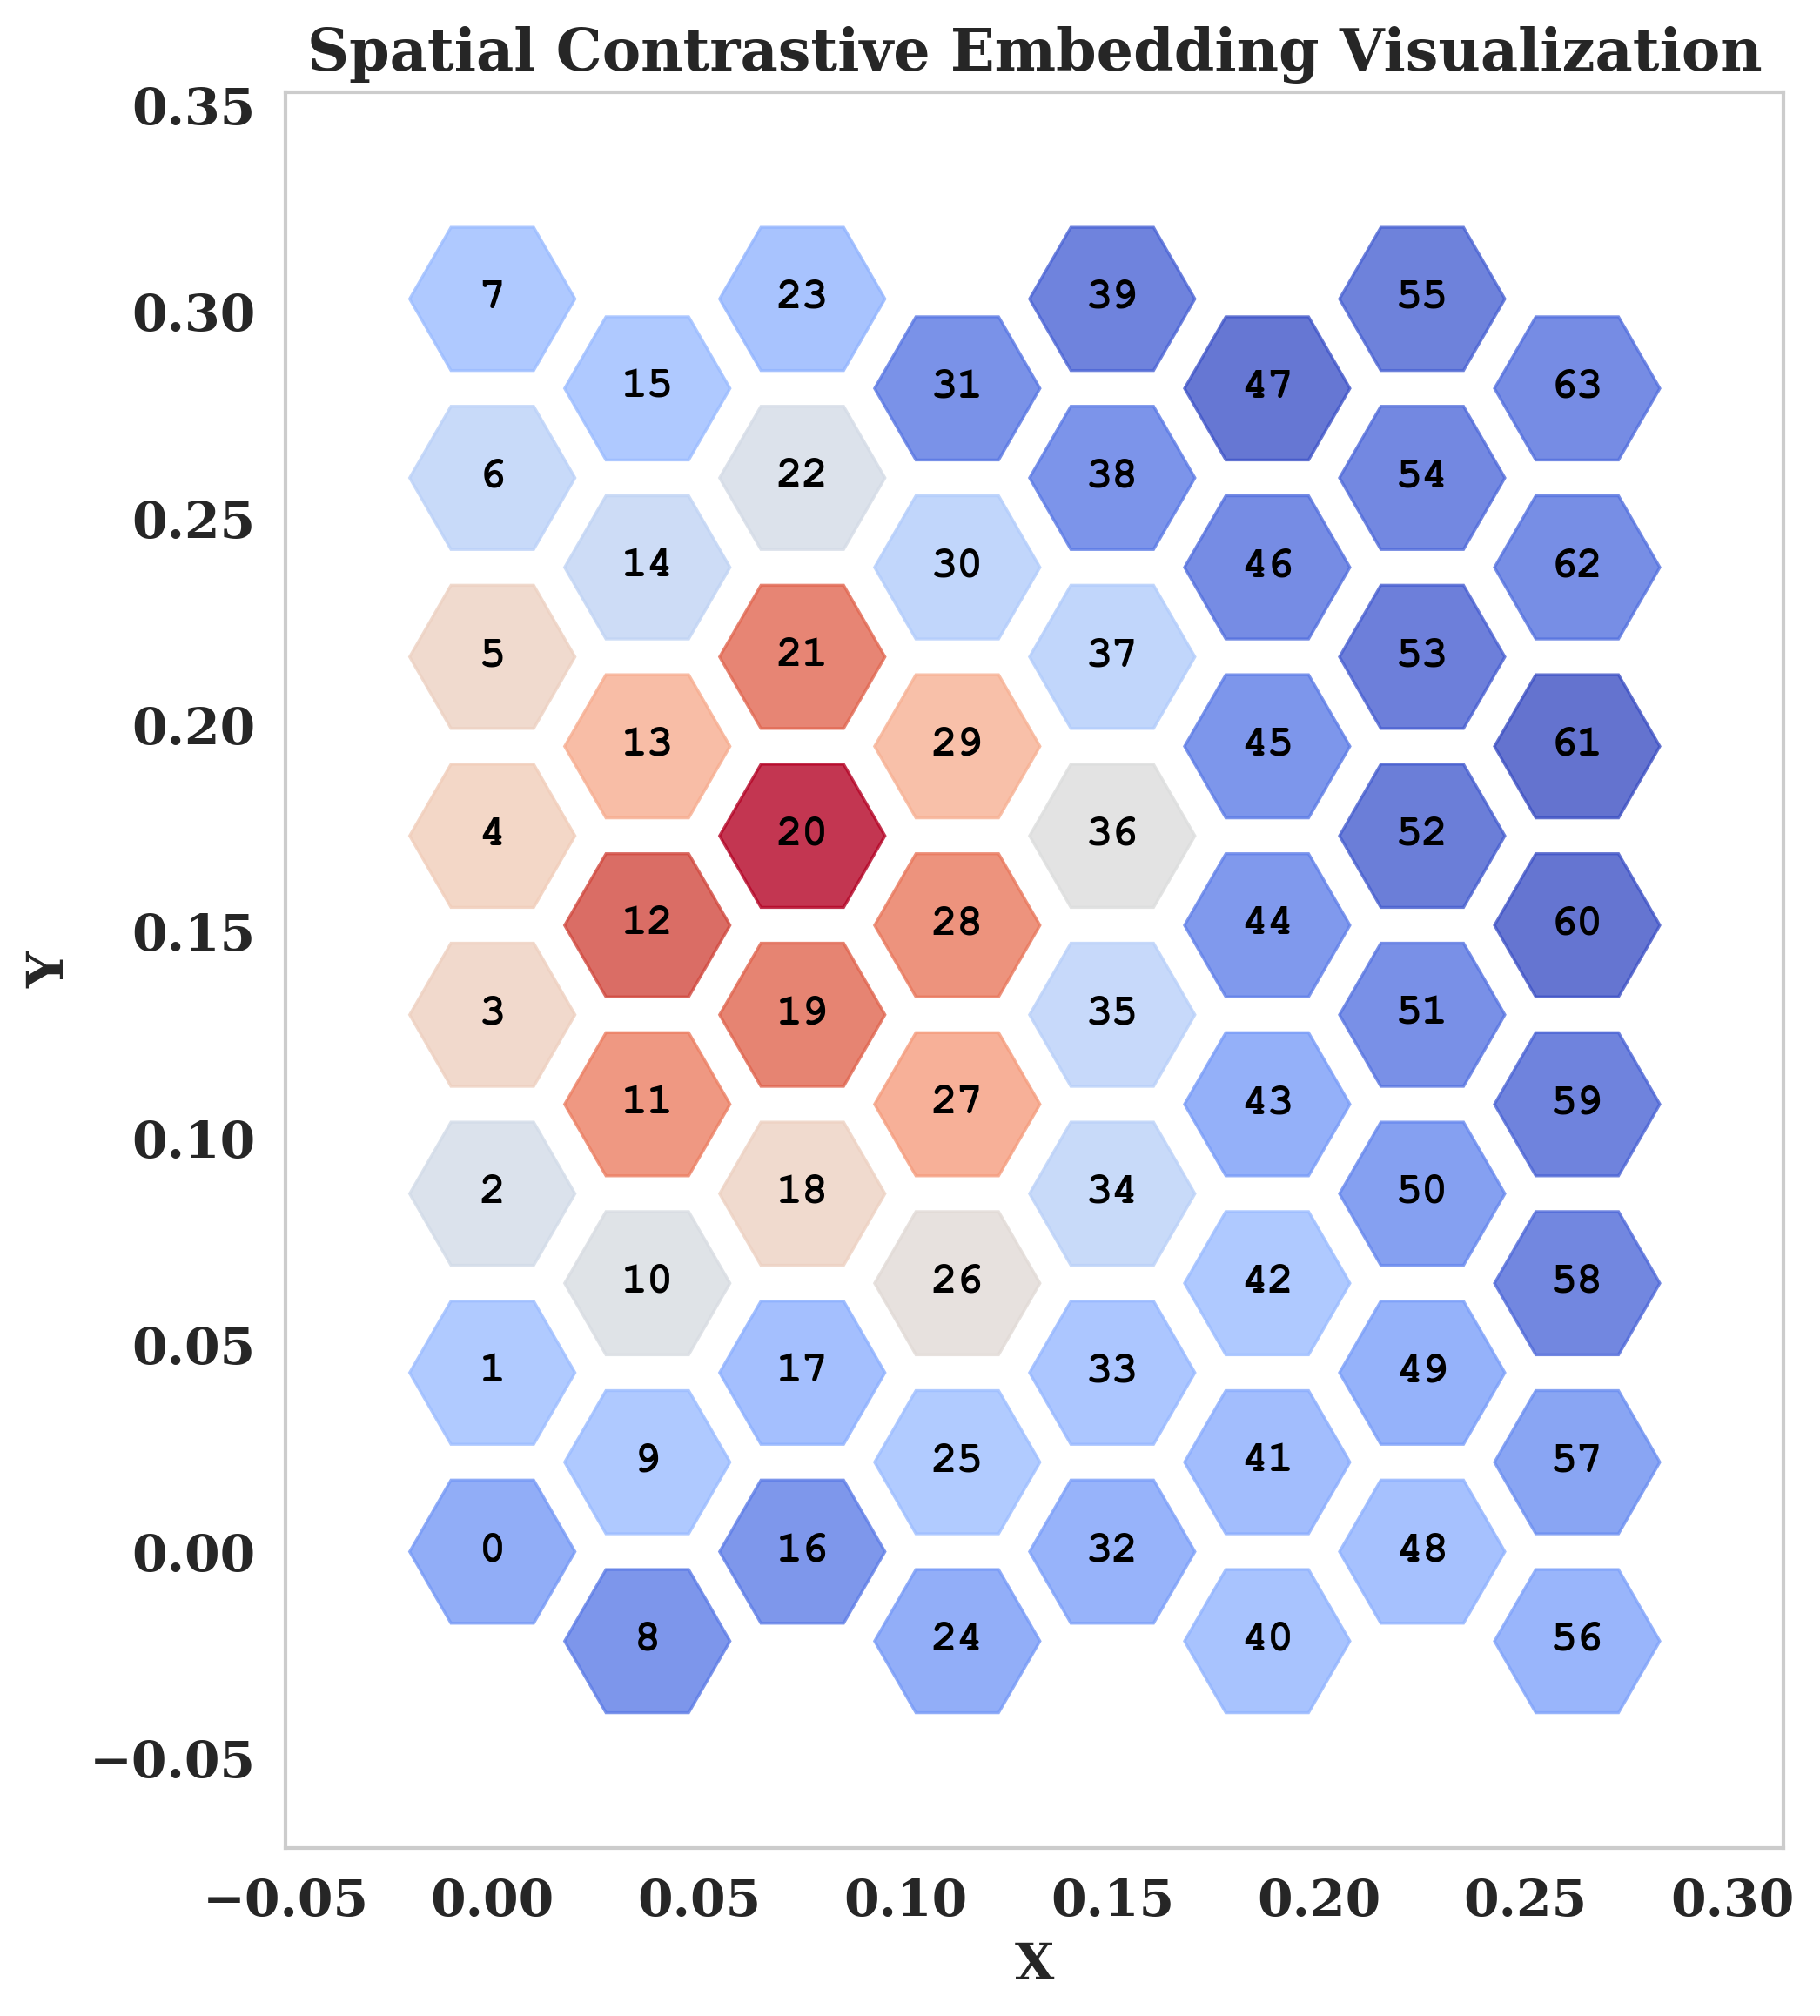

In [82]:
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import RegularPolygon
# mpl.font_manager._rebuild()


rb_pos_world = np.zeros((8,8,2))
for i in range(8):
    for j in range(8):
        if i%2!=0:
            finger_pos = np.array((i*0.0375, j*0.043301 - 0.02165))
            rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301 - 0.02165))
        else:
            finger_pos = np.array((i*0.0375, j*0.043301))
            rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301))

with torch.no_grad():
    all_indices = torch.arange(num_embeddings, device=device)
    embedding_all = model(all_indices).cpu().numpy()

sim_matrix = np.corrcoef(embedding_all)

reference_robots = [20]  # Reference robot(s)
colormaps = ["coolwarm"]

# Extract robot positions
grid_size = 8
x_coords = rb_pos_world[:, :, 0].flatten()
y_coords = rb_pos_world[:, :, 1].flatten()

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Spatial Contrastive Embedding Visualization", fontsize=16)

# Adjust bounds for the hexagonal grid
x_min, x_max = x_coords.min() - 0.05, x_coords.max() + 0.05
y_min, y_max = y_coords.min() - 0.05, y_coords.max() + 0.05
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Plot hexagons for the reference robot
ref_robot = reference_robots[0]
similarities = sim_matrix[ref_robot]
sim_map = similarities.reshape(grid_size, grid_size)

for i in range(grid_size):
    for j in range(grid_size):
        hexagon = RegularPolygon(
            (rb_pos_world[i, j, 0], rb_pos_world[i, j, 1]),
            numVertices=6,
            radius=0.02,
            orientation=np.radians(30),
            color=mpl.colormaps.get_cmap(colormaps[0])(sim_map[i, j]),
            alpha=0.8,
            edgecolor='black'
        )
        ax.add_patch(hexagon)
        ax.text(rb_pos_world[i, j, 0], rb_pos_world[i, j, 1],
                str(i * grid_size + j),
                ha='center', va='center', fontsize=12, color='black', fontname="Courier New", weight='bold')

# Customize appearance
ax.set_xlabel("X", fontsize=14)
ax.set_ylabel("Y", fontsize=14)
ax.set_aspect('equal')
ax.grid(False)

plt.tight_layout()
plt.savefig("hexagonal_visualization.png", dpi=300, bbox_inches='tight')
plt.show()

In [83]:
import matplotlib.font_manager
print(sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist]))

['Abyssinica SIL', 'Andale Mono', 'Andale Mono', 'Ani', 'AnjaliOldLipi', 'Arial', 'Arial', 'Arial', 'Arial', 'Arial', 'Arial', 'Arial', 'Arial', 'Arial Black', 'Arial Black', 'C059', 'C059', 'C059', 'C059', 'Chandas', 'Chilanka', 'Comic Sans MS', 'Comic Sans MS', 'Comic Sans MS', 'Comic Sans MS', 'Courier New', 'Courier New', 'Courier New', 'Courier New', 'Courier New', 'Courier New', 'Courier New', 'Courier New', 'D050000L', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans Display', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif Display', 'Dhurjati', 'Droid Sans Fallback', 'Dyuthi', 'FreeMono', 'FreeMono', 'FreeMono', 'FreeMono', 'FreeSans', 'FreeSans', 'FreeSans', 'FreeSans', 'FreeSerif', 'FreeSerif', 'FreeSerif', 'FreeSerif', 'Gargi', 'Garuda', 'Garu

In [46]:
a.shape, embeddings.shape

NameError: name 'embeddings' is not defined

In [47]:
def generate_sinusoidal_embeddings(num_agents, dimensions):
    position = np.arange(num_agents)[:, np.newaxis]
    div_term = np.exp(np.arange(0, dimensions, 2) * -(np.log(10000.0) / dimensions))
    embeddings = np.zeros((num_agents, dimensions))
    embeddings[:, 0::2] = np.sin(position * div_term)
    embeddings[:, 1::2] = np.cos(position * div_term)
    return embeddings

from sklearn.metrics.pairwise import cosine_similarity
# Generate embeddings
embed1 = generate_sinusoidal_embeddings(64, 128)
embed2 = a.detach().cpu().numpy()
embed2 = embed2 / np.linalg.norm(embed2, axis=1, keepdims=True)
embed1 = torch.tensor(embed1)
embed2 = torch.tensor(embed2)
cos_sim_matrix1 = torch.zeros(64, 64)
cos_sim_matrix2 = torch.zeros(64, 64)
for i in range(64):
    for j in range(64):
        cos_sim_matrix1[i, j] = cos_sim(embed1[i], embed1[j])
        cos_sim_matrix2[i, j] = cos_sim(embed2[i], embed2[j])

# # Plotting the heatmap
# plt.figure(figsize=(12, 8))
# plt.imshow(embeddings, aspect='auto', cmap='viridis')
# plt.colorbar(label='Embedding Value')
# plt.title('Sinusoidal Position Embeddings Heatmap')
# plt.xlabel('Embedding Dimensions')
# plt.ylabel('Agent Index')
# plt.show()
# plt.figure(figsize=(12, 8))
# plt.imshow(embed2, aspect='auto', cmap='viridis')
# plt.colorbar(label='Embedding Value')
# plt.title('Sinusoidal Position Embeddings Heatmap')
# plt.xlabel('Embedding Dimensions')
# plt.ylabel('Agent Index')
# plt.show()

import seaborn as sns

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')
font = {'size': 14}
plt.rc('font', **font)
plt.rc('axes', titlesize=font['size'])
plt.rc('legend', fontsize=10)
plt.rc('figure', dpi=300)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

sns.heatmap(embed1, ax=axes[0, 0], cmap="viridis", cbar=False)
axes[0, 0].set_title('Sinusoidal Position Embeddings')
axes[0, 0].set_xlabel('Embedding Dimensions')
axes[0, 0].set_ylabel('Agent Index')
axes[0, 0].set_yticks(np.arange(0, 65, 8))
axes[0, 0].set_yticklabels(np.arange(0, 65, 8))
axes[0, 0].set_xticks(np.arange(0, 129, 16))
axes[0, 0].set_xticklabels(np.arange(0, 129, 16))

sns.heatmap(embed2, ax=axes[0, 1], cmap="viridis", cbar=False)
axes[0, 1].set_title('Spatial Contrastive Embeddings')
axes[0, 1].set_xlabel('Embedding Dimensions')
axes[0, 1].set_ylabel('Agent Index')
axes[0, 1].set_yticks(np.arange(0, 65, 8))
axes[0, 1].set_yticklabels(np.arange(0, 65, 8))
axes[0, 1].set_xticks(np.arange(0, 129, 16))
axes[0, 1].set_xticklabels(np.arange(0, 129, 16))

sns.heatmap(cos_sim_matrix1, ax=axes[1, 0], cmap="viridis", cbar=False)
axes[1, 0].set_title('SPE Heatmap')
axes[1, 0].set_xlabel('Agent Index')
axes[1, 0].set_ylabel('Agent Index')
axes[1, 0].set_yticks(np.arange(0, 65, 8))
axes[1, 0].set_yticklabels(np.arange(0, 65, 8))
axes[1, 0].set_xticks(np.arange(0, 65, 8))
axes[1, 0].set_xticklabels(np.arange(0, 65, 8))

sns.heatmap(cos_sim_matrix2, ax=axes[1, 1], cmap="viridis", cbar=False)
axes[1, 1].set_title('SCE Heatmap')
axes[1, 1].set_xlabel('Agent Index')
axes[1, 1].set_ylabel('Agent Index')
axes[1, 1].set_yticks(np.arange(0, 65, 8))
axes[1, 1].set_yticklabels(np.arange(0, 65, 8))
axes[1, 1].set_xticks(np.arange(0, 65, 8))
axes[1, 1].set_xticklabels(np.arange(0, 65, 8))

plt.tight_layout()
plt.show()

/tmp/ipykernel_2008557/1824835424.py:199: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  hexagon = RegularPolygon(
/tmp/ipykernel_2008557/1824835424.py:232: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar


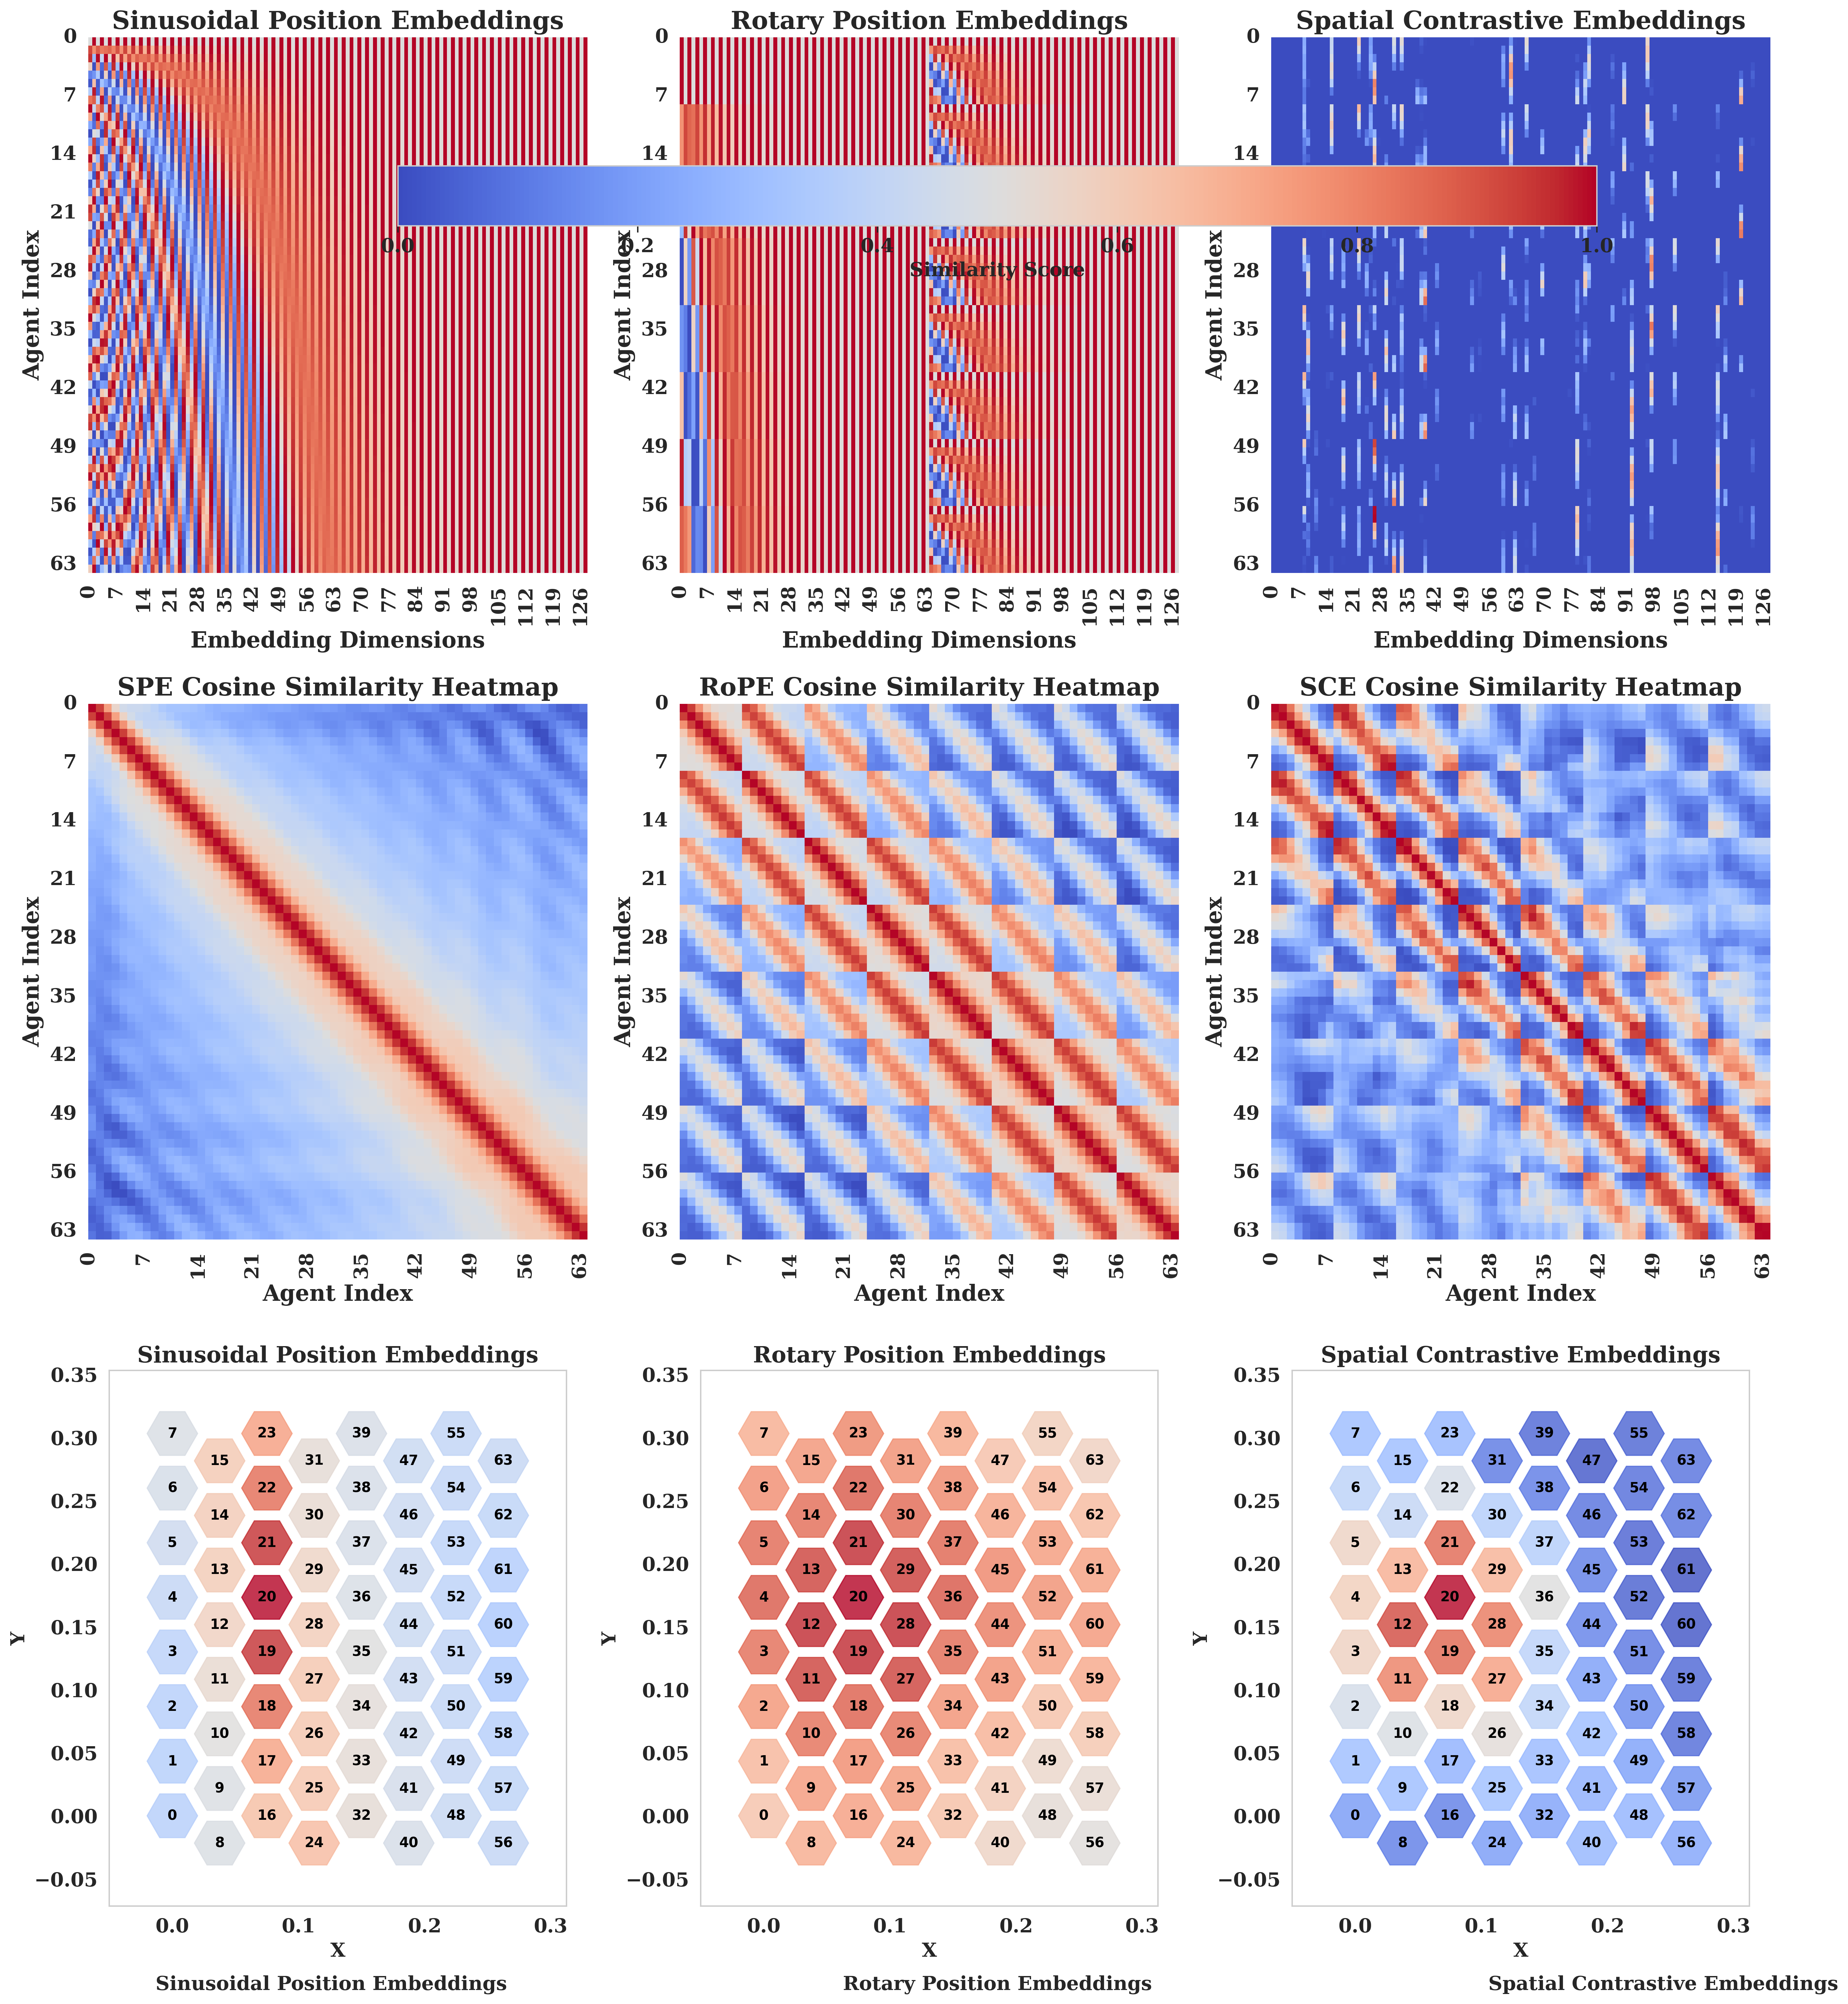

In [89]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Function to generate sinusoidal embeddings
def generate_sinusoidal_embeddings(num_agents, dimensions):
    position = np.arange(num_agents)[:, np.newaxis]
    div_term = np.exp(np.arange(0, dimensions, 2) * -(np.log(10000.0) / dimensions))
    embeddings = np.zeros((num_agents, dimensions))
    embeddings[:, 0::2] = np.sin(position * div_term)
    embeddings[:, 1::2] = np.cos(position * div_term)
    return embeddings

def generate_rotary_embeddings_2d(rows, cols, dimensions):
    """
    Generate RoPE embeddings for a 2D grid of agents
    """
    if dimensions % 4 != 0:  # Need to be divisible by 4 for 2D
        raise ValueError("Dimensions must be divisible by 4 for 2D RoPE")
        
    num_agents = rows * cols
    quarter_dim = dimensions // 4
    
    # Generate frequency bands
    freq = 1.0 / (10000 ** (np.arange(0, quarter_dim) / quarter_dim))
    
    # Create position-dependent phase for both x and y
    pos_x = (np.arange(rows)[:, None] * np.ones((1, cols))).flatten()[:, None]
    pos_y = (np.ones((rows, 1)) * np.arange(cols)[None, :]).flatten()[:, None]
    
    phase_x = pos_x * freq[None, :]  # [num_agents, quarter_dim]
    phase_y = pos_y * freq[None, :]  # [num_agents, quarter_dim]
    
    # Generate embeddings
    embeddings = np.zeros((num_agents, dimensions))
    
    # First half for x-position
    embeddings[:, 0:dimensions//2:2] = np.cos(phase_x)
    embeddings[:, 1:dimensions//2:2] = np.sin(phase_x)
    
    # Second half for y-position
    embeddings[:, dimensions//2::2] = np.cos(phase_y)
    embeddings[:, dimensions//2+1::2] = np.sin(phase_y)
    
    return embeddings

# Generate embeddings
num_agents = 64
dimensions = 128
sinusoidal_embeddings = generate_sinusoidal_embeddings(num_agents, dimensions)
rotary_embeddings = generate_rotary_embeddings_2d(8, 8, dimensions)
contrastive_embeddings = embedding_all

# Normalize embeddings
contrastive_embeddings /= np.linalg.norm(contrastive_embeddings, axis=1, keepdims=True)
sinusoidal_embeddings = torch.tensor(sinusoidal_embeddings)
rotary_embeddings = torch.tensor(rotary_embeddings)
contrastive_embeddings = torch.tensor(contrastive_embeddings)

# Compute cosine similarity matrices
cos_sim_matrix_spe = np.corrcoef(sinusoidal_embeddings.numpy())
cos_sim_matrix_rope = np.corrcoef(rotary_embeddings.numpy())
cos_sim_matrix_sce = np.corrcoef(contrastive_embeddings.numpy())

# Plot embeddings and similarity heatmaps
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 16,               # Base font size
    'font.weight': 'bold',         # Makes the base font bold
    'axes.titlesize': 18,          # Axes title size
    'axes.titleweight': 'bold',    # Makes the axes titles bold
    'axes.labelsize': 16,          # Axes label size
    'axes.labelweight': 'bold',    # Makes the axes labels bold
    'xtick.labelsize': 14,         # X-tick label size
    'ytick.labelsize': 14,         # Y-tick label size
    'figure.titlesize': 20,        # Figure title size
})

fig, axes = plt.subplots(3, 3, figsize=(20, 20))

# Helper function to set ticks every 7 steps
def set_ticks_every_7(ax, data, x_is_dims=True):
    """
    Set x- and y- ticks every 7 steps.
    x_is_dims=True  => x-axis corresponds to data.shape[1]
                       y-axis corresponds to data.shape[0].
    x_is_dims=False => x-axis corresponds to data.shape[0]
                       y-axis corresponds to data.shape[1].
    """
    # Adjust based on whether data's shape corresponds
    # to (num_rows, num_cols) = (agents, embedding_dims) or something else
    if x_is_dims:
        x_len = data.shape[1]
        y_len = data.shape[0]
    else:
        x_len = data.shape[0]
        y_len = data.shape[1]

    ax.set_xticks(np.arange(0, x_len, 7))
    ax.set_yticks(np.arange(0, y_len, 7))
    # (Optionally) set the labels if you'd like them to match the numeric range:
    ax.set_xticklabels(np.arange(0, x_len, 7))
    ax.set_yticklabels(np.arange(0, y_len, 7))

# ============== Sinusoidal Position Embeddings ==============
sns.heatmap(sinusoidal_embeddings, ax=axes[0, 0], cmap=plt.cm.coolwarm, cbar=False)
axes[0, 0].set_title('Embeddings')
axes[0, 0].set_xlabel('Embedding Dimensions')
axes[0, 0].set_ylabel('Agent Index')
set_ticks_every_7(axes[0, 0], sinusoidal_embeddings, x_is_dims=True)

# ============== Rotary Position Embeddings ==============
sns.heatmap(rotary_embeddings, ax=axes[0, 1], cmap=plt.cm.coolwarm, cbar=False)
axes[0, 1].set_title('Embeddings')
axes[0, 1].set_xlabel('Embedding Dimensions')
axes[0, 1].set_ylabel('Agent Index')
set_ticks_every_7(axes[0, 1], rotary_embeddings, x_is_dims=True)

# ============== Spatial Contrastive Embeddings ==============
sns.heatmap(contrastive_embeddings, ax=axes[0, 2], cmap=plt.cm.coolwarm, cbar=False)
axes[0, 2].set_title('Embeddings')
axes[0, 2].set_xlabel('Embedding Dimensions')
axes[0, 2].set_ylabel('Agent Index')
set_ticks_every_7(axes[0, 2], contrastive_embeddings, x_is_dims=True)

# ============== SPE Heatmap ==============
sns.heatmap(cos_sim_matrix_spe, ax=axes[1, 0], cmap=plt.cm.coolwarm, cbar=False)
axes[1, 0].set_title('Similarity Heatmap')
axes[1, 0].set_xlabel('Agent Index')
axes[1, 0].set_ylabel('Agent Index')
set_ticks_every_7(axes[1, 0], cos_sim_matrix_spe, x_is_dims=False)

# ============== RoPE Heatmap ==============
sns.heatmap(cos_sim_matrix_rope, ax=axes[1, 1], cmap=plt.cm.coolwarm, cbar=False)
axes[1, 1].set_title('Similarity Heatmap')
axes[1, 1].set_xlabel('Agent Index')
axes[1, 1].set_ylabel('Agent Index')
set_ticks_every_7(axes[1, 1], cos_sim_matrix_rope, x_is_dims=False)

# ============== SCE Heatmap ==============
sns.heatmap(cos_sim_matrix_sce, ax=axes[1, 2], cmap=plt.cm.coolwarm, cbar=False)
axes[1, 2].set_title('Similarity Heatmap')
axes[1, 2].set_xlabel('Agent Index')
axes[1, 2].set_ylabel('Agent Index')
set_ticks_every_7(axes[1, 2], cos_sim_matrix_sce, x_is_dims=False)

# Generate hexagonal grid positions
rb_pos_world = np.zeros((8, 8, 2))
for i in range(8):
    for j in range(8):
        if i % 2 != 0:
            rb_pos_world[i, j] = [i * 0.0375, j * 0.043301 - 0.02165]
        else:
            rb_pos_world[i, j] = [i * 0.0375, j * 0.043301]

# Create a figure with three subplots side by side
# fig, axes = plt.subplots(1, 3, figsize=(24, 8))
# fig.suptitle("Comparison of Different Embeddings", fontsize=20, y=1.02)

embeddings = [
    (cos_sim_matrix_spe, "Sinusoidal Position Embeddings"),
    (cos_sim_matrix_rope, "Rotary Position Embeddings"),
    (cos_sim_matrix_sce, "Spatial Contrastive Embeddings")
]

for idx, (embed, title) in enumerate(embeddings):
    sim_matrix = embed
    reference_robots = [20]  # Reference robot(s)

    # Extract robot positions
    x_coords = rb_pos_world[:, :, 0].flatten()
    y_coords = rb_pos_world[:, :, 1].flatten()

    # Set up subplot
    ax = axes[2, idx]
    # ax.axis('off')
    # plt.gca().set_frame_on(True)
    ax.set_title(title, fontsize=16)

    # Adjust bounds for the hexagonal grid
    x_min, x_max = x_coords.min() - 0.05, x_coords.max() + 0.05
    y_min, y_max = y_coords.min() - 0.05, y_coords.max() + 0.05
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Plot hexagons
    ref_robot = reference_robots[0]
    similarities = sim_matrix[ref_robot]
    sim_map = similarities.reshape(8, 8)

    for i in range(8):
        for j in range(8):
            hexagon = RegularPolygon(
                (rb_pos_world[i, j, 0], rb_pos_world[i, j, 1]),
                numVertices=6,
                radius=0.02,
                orientation=np.radians(30),
                color=plt.cm.coolwarm(sim_map[i, j]),
                alpha=0.8,
                edgecolor='black'
            )
            ax.add_patch(hexagon)
            ax.text(rb_pos_world[i, j, 0], rb_pos_world[i, j, 1],
                    str(i * 8 + j),
                    ha='center', va='center', fontsize=10,
                    color='black', fontname="DejaVu Sans", weight='bold')

    # Customize appearance
    ax.set_xlabel("X", fontsize=14)
    ax.set_ylabel("Y", fontsize=14)
    ax.set_aspect('equal')
    ax.grid(False)

# Add a colorbar
fig.subplots_adjust(top=0.85)  # Increase the top margin
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cax = fig.add_axes([0.2, 0.88, 0.6, 0.03])
cb = mpl.colorbar.ColorbarBase(cax, cmap=plt.cm.coolwarm, norm=norm, orientation='horizontal')
cb.set_label('Similarity Score', fontsize=14)


fig.text(0.33333/2, 0, 'Sinusoidal Position Embeddings', va='center', ha='center', rotation='horizontal', fontsize=14)
fig.text(0.5, 0, 'Rotary Position Embeddings', va='center', ha='center', rotation='horizontal', fontsize=14)
fig.text(1 - 0.33333/2, 0, 'Spatial Contrastive Embeddings', va='center', ha='center', rotation='horizontal', fontsize=14)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar
plt.show()
fig.savefig("similarity_w_bbox.png", dpi=300, bbox_inches='tight')


/tmp/ipykernel_2008557/1706569041.py:174: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  hexagon = RegularPolygon(


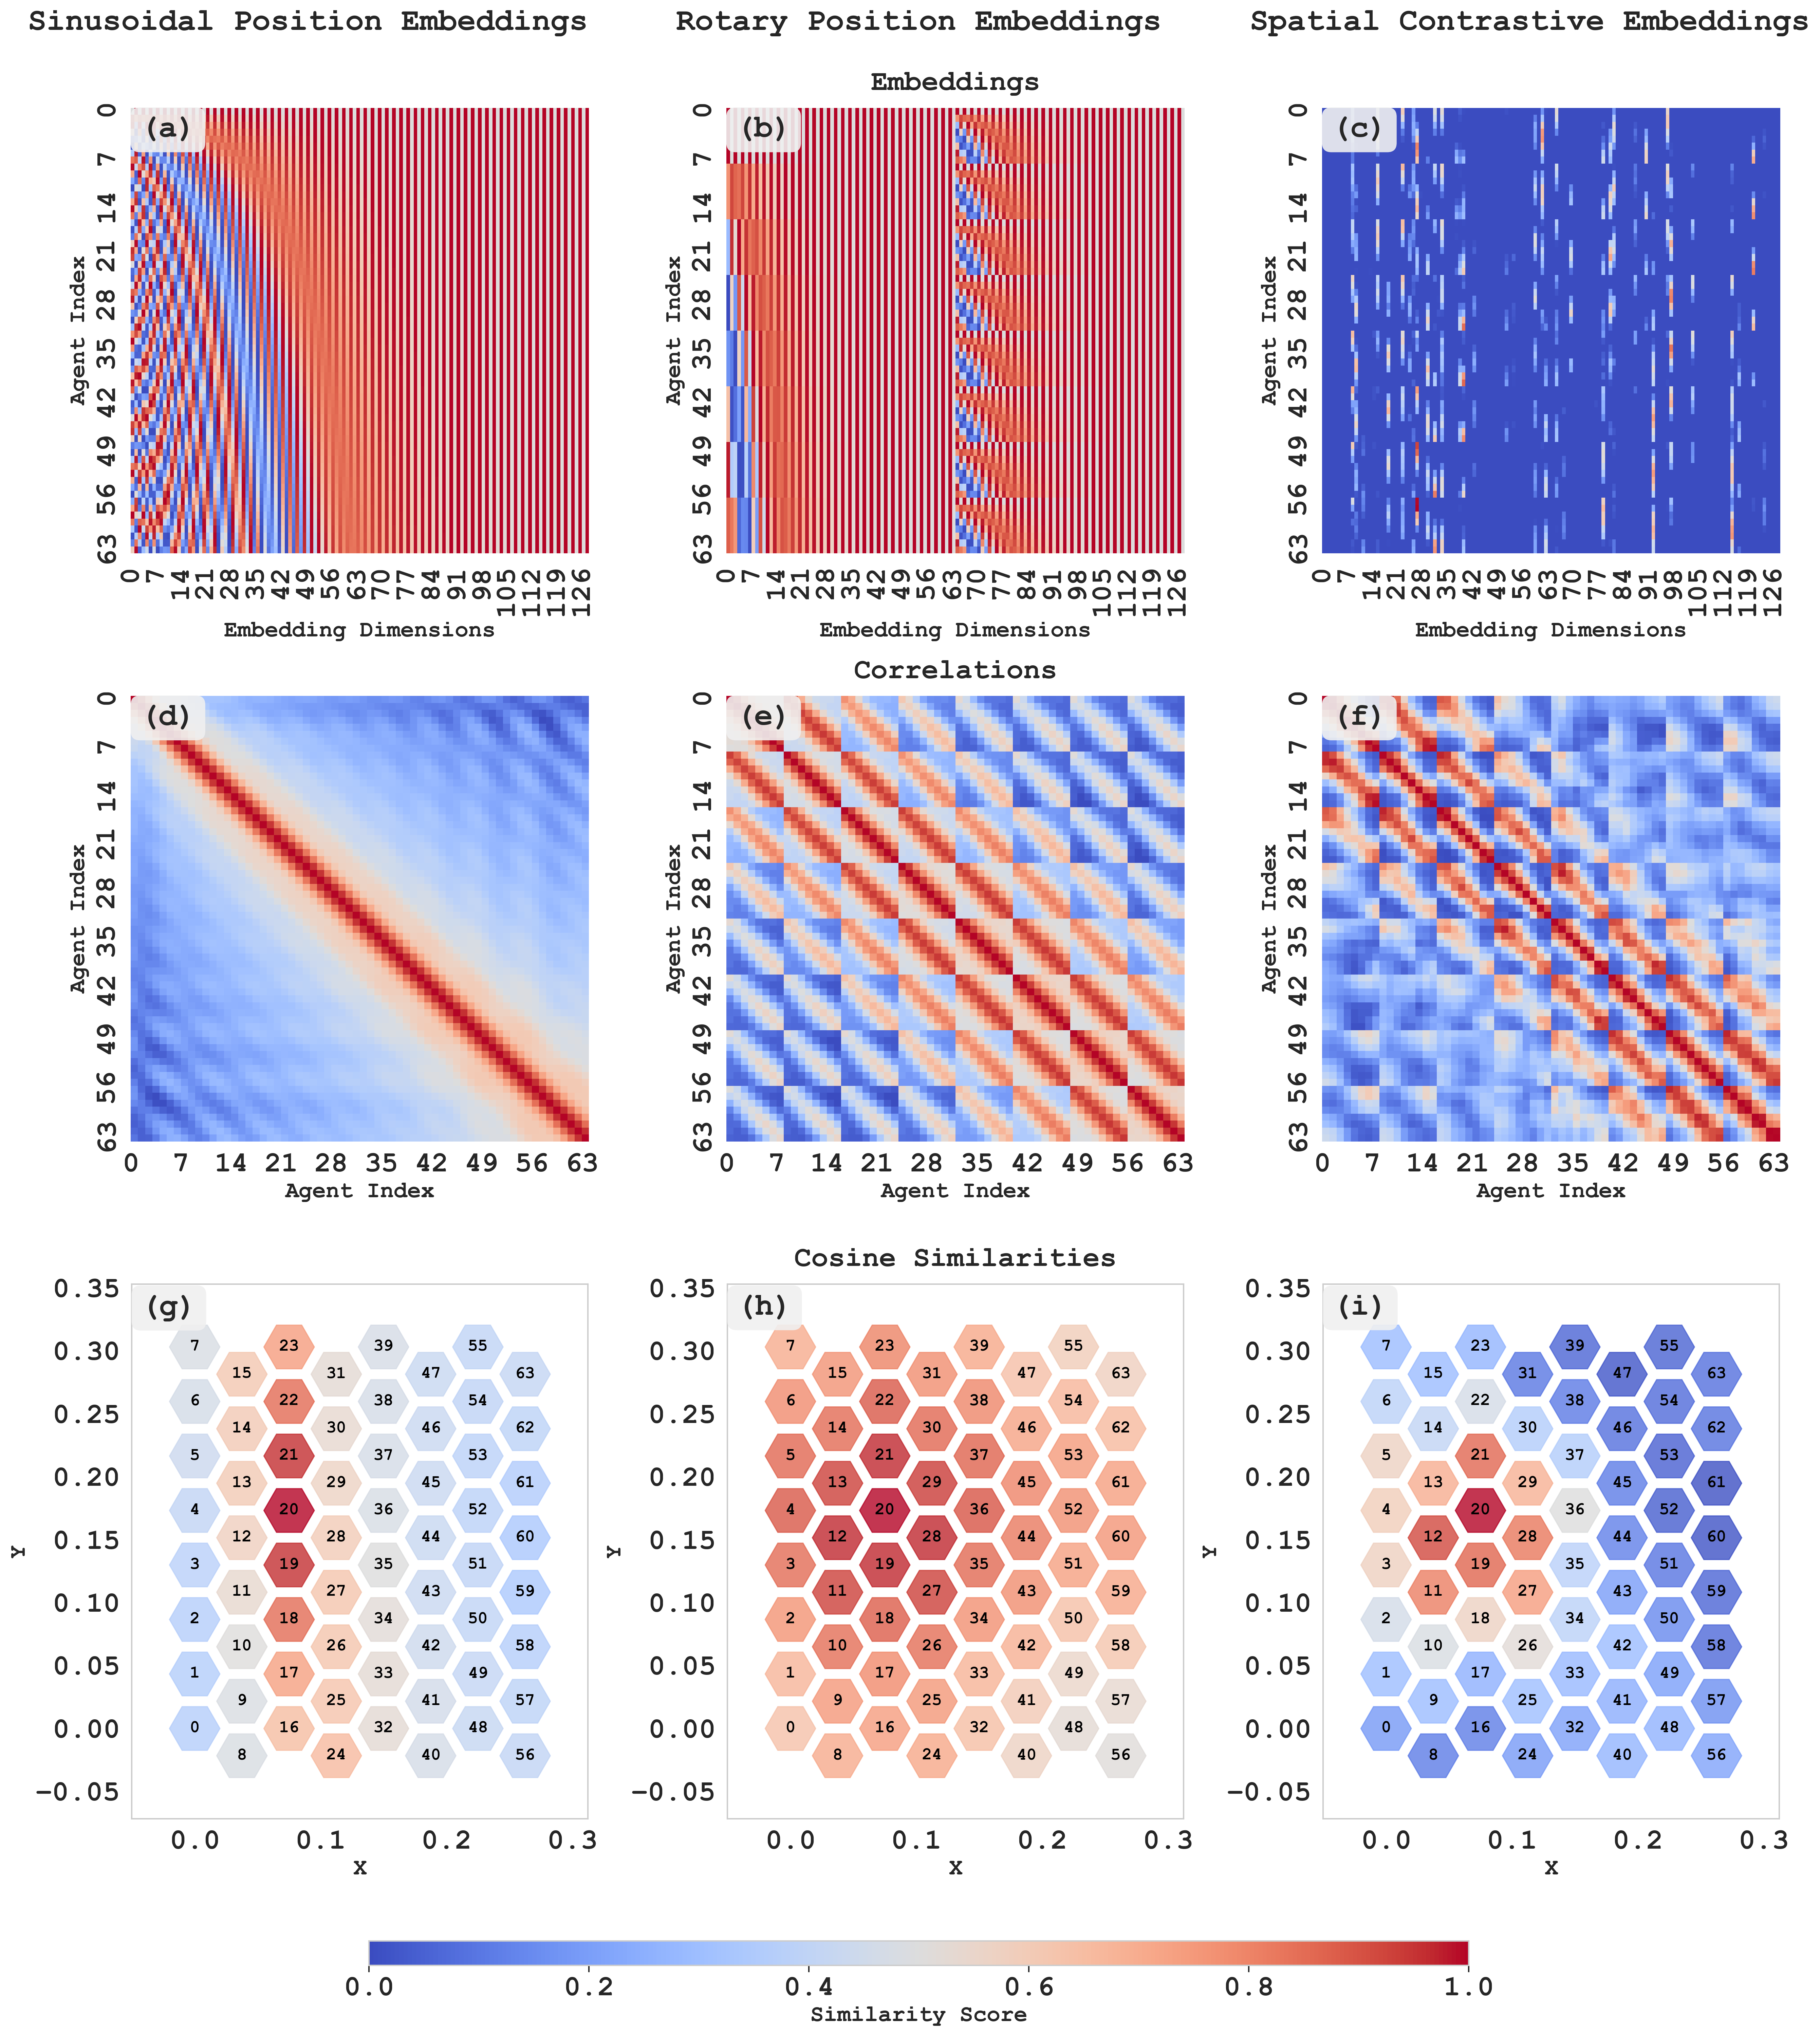

In [111]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
import torch
import seaborn as sns

# =============================================================================
# User‐defined font-size “plugs”
# =============================================================================
ROW_TITLE_FS = 20      # Row-level titles (spanning a full row)
COL_LABEL_FS = 22      # Column labels (for the entire columns)
AXES_LABEL_FS = 16     # Axes (x and y) labels for individual subplots
SUBPLOT_LABEL_FS = 22  # Labels like (a), (b), (c), … for each subplot
HEX_TEXT_FS = 12       # Font size for text inside 1

# =============================================================================
# Update rcParams: use Courier New Bold for everything
# =============================================================================
plt.rcParams.update({
    'font.family': 'Courier New',
    'font.weight': 'bold',
    'font.size': 20,               # Base font size
    'axes.titlesize': 22,          # (unused below since we remove individual titles)
    'axes.titleweight': 'bold',
    'axes.labelsize': AXES_LABEL_FS,
    'axes.labelweight': 'bold',
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'figure.titlesize': 24,
})

# =============================================================================
# Functions to generate embeddings
# =============================================================================
def generate_sinusoidal_embeddings(num_agents, dimensions):
    position = np.arange(num_agents)[:, np.newaxis]
    div_term = np.exp(np.arange(0, dimensions, 2) * -(np.log(10000.0) / dimensions))
    embeddings = np.zeros((num_agents, dimensions))
    embeddings[:, 0::2] = np.sin(position * div_term)
    embeddings[:, 1::2] = np.cos(position * div_term)
    return embeddings

def generate_rotary_embeddings_2d(rows, cols, dimensions):
    if dimensions % 4 != 0:
        raise ValueError("Dimensions must be divisible by 4 for 2D RoPE")
    num_agents = rows * cols
    quarter_dim = dimensions // 4
    freq = 1.0 / (10000 ** (np.arange(0, quarter_dim) / quarter_dim))
    pos_x = (np.arange(rows)[:, None] * np.ones((1, cols))).flatten()[:, None]
    pos_y = (np.ones((rows, 1)) * np.arange(cols)[None, :]).flatten()[:, None]
    phase_x = pos_x * freq[None, :]
    phase_y = pos_y * freq[None, :]
    embeddings = np.zeros((num_agents, dimensions))
    embeddings[:, 0:dimensions//2:2] = np.cos(phase_x)
    embeddings[:, 1:dimensions//2:2] = np.sin(phase_x)
    embeddings[:, dimensions//2::2] = np.cos(phase_y)
    embeddings[:, dimensions//2+1::2] = np.sin(phase_y)
    return embeddings

# =============================================================================
# Generate embeddings and normalize
# =============================================================================
num_agents = 64
dimensions = 128
sinusoidal_embeddings = generate_sinusoidal_embeddings(num_agents, dimensions)
rotary_embeddings = generate_rotary_embeddings_2d(8, 8, dimensions)
contrastive_embeddings = embedding_all  # <<< make sure embedding_all is defined

# Normalize contrastive embeddings
contrastive_embeddings /= np.linalg.norm(contrastive_embeddings, axis=1, keepdims=True)
sinusoidal_embeddings = torch.tensor(sinusoidal_embeddings)
rotary_embeddings = torch.tensor(rotary_embeddings)
contrastive_embeddings = torch.tensor(contrastive_embeddings)

# =============================================================================
# Compute cosine similarity matrices
# =============================================================================
cos_sim_matrix_spe = np.corrcoef(sinusoidal_embeddings.numpy())
cos_sim_matrix_rope = np.corrcoef(rotary_embeddings.numpy())
cos_sim_matrix_sce = np.corrcoef(contrastive_embeddings.numpy())

# =============================================================================
# Create a 3x3 grid of subplots and adjust layout
# =============================================================================
fig, axes = plt.subplots(3, 3, figsize=(18, 24),
                         gridspec_kw={'height_ratios': [1, 1, 1.2]})
# Leave room for the colorbar and our row/column titles
fig.subplots_adjust(top=0.78, bottom=0.08, left=0.07, right=0.97, wspace=0.3, hspace=0.3)

# =============================================================================
# Helper: set ticks every 7 steps
# =============================================================================
def set_ticks_every_7(ax, data, x_is_dims=True):
    if x_is_dims:
        x_len = data.shape[1]
        y_len = data.shape[0]
    else:
        x_len = data.shape[0]
        y_len = data.shape[1]
    ax.set_xticks(np.arange(0, x_len, 7))
    ax.set_yticks(np.arange(0, y_len, 7))
    ax.set_xticklabels(np.arange(0, x_len, 7))
    ax.set_yticklabels(np.arange(0, y_len, 7))

# =============================================================================
# Row 0: Embeddings Heatmaps
# =============================================================================
sns.heatmap(sinusoidal_embeddings, ax=axes[0, 0], cmap=plt.cm.coolwarm, cbar=False)
axes[0, 0].set_xlabel('Embedding Dimensions', fontsize=AXES_LABEL_FS)
axes[0, 0].set_ylabel('Agent Index', fontsize=AXES_LABEL_FS)
set_ticks_every_7(axes[0, 0], sinusoidal_embeddings, x_is_dims=True)

sns.heatmap(rotary_embeddings, ax=axes[0, 1], cmap=plt.cm.coolwarm, cbar=False)
axes[0, 1].set_xlabel('Embedding Dimensions', fontsize=AXES_LABEL_FS)
axes[0, 1].set_ylabel('Agent Index', fontsize=AXES_LABEL_FS)
set_ticks_every_7(axes[0, 1], rotary_embeddings, x_is_dims=True)

sns.heatmap(contrastive_embeddings, ax=axes[0, 2], cmap=plt.cm.coolwarm, cbar=False)
axes[0, 2].set_xlabel('Embedding Dimensions', fontsize=AXES_LABEL_FS)
axes[0, 2].set_ylabel('Agent Index', fontsize=AXES_LABEL_FS)
set_ticks_every_7(axes[0, 2], contrastive_embeddings, x_is_dims=True)

# =============================================================================
# Row 1: Similarity Heatmaps
# =============================================================================
sns.heatmap(cos_sim_matrix_spe, ax=axes[1, 0], cmap=plt.cm.coolwarm, cbar=False)
axes[1, 0].set_xlabel('Agent Index', fontsize=AXES_LABEL_FS)
axes[1, 0].set_ylabel('Agent Index', fontsize=AXES_LABEL_FS)
set_ticks_every_7(axes[1, 0], cos_sim_matrix_spe, x_is_dims=False)

sns.heatmap(cos_sim_matrix_rope, ax=axes[1, 1], cmap=plt.cm.coolwarm, cbar=False)
axes[1, 1].set_xlabel('Agent Index', fontsize=AXES_LABEL_FS)
axes[1, 1].set_ylabel('Agent Index', fontsize=AXES_LABEL_FS)
set_ticks_every_7(axes[1, 1], cos_sim_matrix_rope, x_is_dims=False)

sns.heatmap(cos_sim_matrix_sce, ax=axes[1, 2], cmap=plt.cm.coolwarm, cbar=False)
axes[1, 2].set_xlabel('Agent Index', fontsize=AXES_LABEL_FS)
axes[1, 2].set_ylabel('Agent Index', fontsize=AXES_LABEL_FS)
set_ticks_every_7(axes[1, 2], cos_sim_matrix_sce, x_is_dims=False)

# =============================================================================
# Row 2: Hexagonal Grid Similarity Visualizations
# =============================================================================
# Create hexagonal grid positions
rb_pos_world = np.zeros((8, 8, 2))
for i in range(8):
    for j in range(8):
        if i % 2 != 0:
            rb_pos_world[i, j] = [i * 0.0375, j * 0.043301 - 0.02165]
        else:
            rb_pos_world[i, j] = [i * 0.0375, j * 0.043301]

embeddings_list = [
    (cos_sim_matrix_spe, "Sinusoidal Position Embeddings"),
    (cos_sim_matrix_rope, "Rotary Position Embeddings"),
    (cos_sim_matrix_sce, "Spatial Contrastive Embeddings")
]

for idx, (embed, col_title) in enumerate(embeddings_list):
    sim_matrix = embed
    reference_robot = 20  # Choose a reference robot index
    x_coords = rb_pos_world[:, :, 0].flatten()
    y_coords = rb_pos_world[:, :, 1].flatten()
    ax = axes[2, idx]
    x_min, x_max = x_coords.min() - 0.05, x_coords.max() + 0.05
    y_min, y_max = y_coords.min() - 0.05, y_coords.max() + 0.05
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    # Reshape similarities into the 8x8 grid
    sim_map = sim_matrix[reference_robot].reshape(8, 8)
    for i in range(8):
        for j in range(8):
            hexagon = RegularPolygon(
                (rb_pos_world[i, j, 0], rb_pos_world[i, j, 1]),
                numVertices=6,
                radius=0.02,
                orientation=np.radians(30),
                color=plt.cm.coolwarm(sim_map[i, j]),
                alpha=0.8,
                edgecolor='black'
            )
            ax.add_patch(hexagon)
            ax.text(rb_pos_world[i, j, 0], rb_pos_world[i, j, 1],
                    str(i * 8 + j),
                    ha='center', va='center', fontsize=HEX_TEXT_FS,
                    color='black', fontfamily="Courier New", fontweight='bold')
    ax.set_xlabel("X", fontsize=AXES_LABEL_FS)
    ax.set_ylabel("Y", fontsize=AXES_LABEL_FS)
    ax.set_aspect('equal')
    ax.grid(False)

# =============================================================================
# Add row-level titles (one per row spanning all three columns)
# =============================================================================
row_titles = ["Embeddings", "Correlations", "Cosine Similarities"]
for r in range(3):
    pos_left = axes[r, 0].get_position().x0
    pos_right = axes[r, -1].get_position().x1
    x_center = (pos_left + pos_right) / 2
    # Place each row title just above the top of the first column in that row
    y = axes[r, 0].get_position().y1 + 0.005
    fig.text(x_center, y, row_titles[r], ha='center', va='bottom',
             fontsize=ROW_TITLE_FS, fontfamily='Courier New', fontweight='bold')

# =============================================================================
# Add column labels (one per column along the bottom)
# =============================================================================
column_labels = ['Sinusoidal Position Embeddings', 'Rotary Position Embeddings', 'Spatial Contrastive Embeddings']
fig.text(0.33333/2, 0.82, column_labels[0], ha='center', va='top',
         fontsize=COL_LABEL_FS, fontfamily='Courier New', fontweight='bold')
fig.text(0.5, 0.82, column_labels[1], ha='center', va='top',
         fontsize=COL_LABEL_FS, fontfamily='Courier New', fontweight='bold')
fig.text(1 - 0.33333/2, 0.82, column_labels[2], ha='center', va='top',
         fontsize=COL_LABEL_FS, fontfamily='Courier New', fontweight='bold')

# =============================================================================
# Add an overall colorbar above the subplots (in its own axes)
# =============================================================================
norm = mpl.colors.Normalize(vmin=0, vmax=1)
# The coordinates [left, bottom, width, height] are in figure fraction
cax = fig.add_axes([0.2, 0.02, 0.6, 0.01])
cb = mpl.colorbar.ColorbarBase(cax, cmap=plt.cm.coolwarm, norm=norm, orientation='horizontal')
cb.set_label('Similarity Score', fontsize=AXES_LABEL_FS, fontfamily='Courier New', fontweight='bold')

# =============================================================================
# Add subplot labels (a), (b), (c), …, (i) to each subplot
# =============================================================================
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
for ax, label in zip(axes.flatten(), subplot_labels):
    ax.text(0.02, 0.98, label, transform=ax.transAxes,
        fontsize=SUBPLOT_LABEL_FS, fontfamily='Courier New', fontweight='bold',
        va='top', ha='left',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='#f0f0f0', edgecolor='none', alpha=0.9))

plt.show()
fig.savefig("similarity_w_bbox.png", dpi=300, bbox_inches='tight')


In [56]:
# torch.save(model.state_dict(), 'idx_embedding_128.pth')

In [135]:
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#################################
# Configuration / Setup
#################################
# You can group your runs by category for convenience.
# For each category, list the run names (or run IDs) you want to include.

# For all expts seeds are: 13, 69, 420, 555, 768
MATSAC_SA_runs = [
    "sbp_team/MARL_Dexterous_Manipulation/edypxdck",  # e.g., "user/MARL_Dexterous_Manipulation/abc123"
    "sbp_team/MARL_Dexterous_Manipulation/isvi3i1i",
    "sbp_team/MARL_Dexterous_Manipulation/si4j2ehm",
    "sbp_team/MARL_Dexterous_Manipulation/34wmnwcv",
    "sbp_team/MARL_Dexterous_Manipulation/xlhj4429",
]

MATSAC_CA_runs = [
    "sbp_team/MARL_Dexterous_Manipulation/014kayig",
    "sbp_team/MARL_Dexterous_Manipulation/gv914b1f",
    "sbp_team/MARL_Dexterous_Manipulation/y7uw7wo4",
    "sbp_team/MARL_Dexterous_Manipulation/l9k0908s",
    "sbp_team/MARL_Dexterous_Manipulation/wj0tc1gq",
]

MATSAC_AdaLN_runs = [
    "sbp_team/MARL_Dexterous_Manipulation/f0cre312",
    "sbp_team/MARL_Dexterous_Manipulation/zwhz6a8b",
    "sbp_team/MARL_Dexterous_Manipulation/llexawps",
    "sbp_team/MARL_Dexterous_Manipulation/phy6nukf",
    "sbp_team/MARL_Dexterous_Manipulation/r3f5lbvz",
]

MATPPO_runs = [
    "sbp_team/MARL_Dexterous_Manipulation/4pq4x4fv",
    "sbp_team/MARL_Dexterous_Manipulation/mvl6unl6",
    "sbp_team/MARL_Dexterous_Manipulation/jmglg51t",
]

MATSAC_SPE_runs = [
    "sbp_team/MARL_Dexterous_Manipulation/rpyqpv71",
    "sbp_team/MARL_Dexterous_Manipulation/h1inac0m",
    "sbp_team/MARL_Dexterous_Manipulation/j590gme5",
]

MATSAC_RoPE_runs=[
    "sbp_team/MARL_Dexterous_Manipulation/6x9f77pl",
    "sbp_team/MARL_Dexterous_Manipulation/92j3y2zl",
    "sbp_team/MARL_Dexterous_Manipulation/st3g42sa"
]

MATSAC_AdaLN_Finetune_runs = [
    "sbp_team/MARL_Dexterous_Manipulation/634e50z4",  
    "sbp_team/MARL_Dexterous_Manipulation/h739jwej",  
    "sbp_team/MARL_Dexterous_Manipulation/sfbch3fx",  
]

MATSAC_Rope_runs = [
    "sbp_team/MARL_Dexterous_Manipulation/u5jdp70l",
    "sbp_team/MARL_Dexterous_Manipulation/8f0l2kzj",
]

MATSAC_RopeFinetune_runs = [
    "sbp_team/MARL_Dexterous_Manipulation/otv5j6y7",
    "sbp_team/MARL_Dexterous_Manipulation/1ak45235", # 420
]

METRICS_TO_PULL = ["Inference Reward"]

# Plot settings
sns.set_theme(context="paper", style="whitegrid", font_scale=1.3)
plt.rcParams.update({
    "figure.dpi": 150,
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
})

#################################
# Data Retrieval
#################################

def fetch_run_history(run_path, metrics):
    """
    Fetches history (pandas DataFrame) for a given W&B run path (e.g. "user/project/run_id"),
    including only the specified metrics.
    """
    api = wandb.Api()
    run = api.run(run_path)
    
    # We only keep the columns we care about
    history = run.history(keys=metrics)
    history["run_name"] = run.name or run.id  # Add a column for run name
    return history


def build_combined_df(runs_list, run_label, metrics):
    """
    Loops over runs in runs_list, fetches the history for each,
    and concatenates them into a single DataFrame with an extra label column.
    """
    dfs = []
    for r in runs_list:
        df_tmp = fetch_run_history(r, metrics)
        df_tmp["category"] = run_label  # e.g., "MATSAC_SA" or "MATSAC_CA"
        dfs.append(df_tmp)
    combined = pd.concat(dfs, ignore_index=True)
    return combined


# Build a master DataFrame with data from all run categories.
master_df = pd.DataFrame()

# Example: MATSAC SA
if MATSAC_SA_runs:
    df_sa = build_combined_df(MATSAC_SA_runs, "MATSAC_SA", METRICS_TO_PULL)
    master_df = pd.concat([master_df, df_sa], ignore_index=True)

# Example: MATSAC CA
if MATSAC_CA_runs:
    df_ca = build_combined_df(MATSAC_CA_runs, "MATSAC_CA", METRICS_TO_PULL)
    master_df = pd.concat([master_df, df_ca], ignore_index=True)

# Example: MATSAC AdaLN
if MATSAC_AdaLN_runs:
    df_adaln = build_combined_df(MATSAC_AdaLN_runs, "MATSAC_AdaLN", METRICS_TO_PULL)
    master_df = pd.concat([master_df, df_adaln], ignore_index=True)
    
if MATPPO_runs:
    df_ppo = build_combined_df(MATPPO_runs, "MATPPO", METRICS_TO_PULL)
    master_df = pd.concat([master_df, df_ppo], ignore_index=True)

if MATSAC_SPE_runs:
    df_adaln = build_combined_df(MATSAC_SPE_runs, "MATSAC_SPE", METRICS_TO_PULL)
    master_df = pd.concat([master_df, df_adaln], ignore_index=True)
    
if MATSAC_RoPE_runs:
    df_adaln = build_combined_df(MATSAC_RoPE_runs, "MATSAC_RoPE", METRICS_TO_PULL)
    master_df = pd.concat([master_df, df_adaln], ignore_index=True)
        
if MATSAC_AdaLN_Finetune_runs:
    df_adaln = build_combined_df(MATSAC_AdaLN_Finetune_runs, "MATSAC_AdaLN_FineTune", METRICS_TO_PULL)
    master_df = pd.concat([master_df, df_adaln], ignore_index=True)

# Example: MATSAC Rope
if MATSAC_Rope_runs:
    df_rope = build_combined_df(MATSAC_Rope_runs, "MATSAC_Rope", METRICS_TO_PULL)
    master_df = pd.concat([master_df, df_rope], ignore_index=True)

# Example: MATSAC Rope Finetune
if MATSAC_RopeFinetune_runs:
    df_rope_ft = build_combined_df(MATSAC_RopeFinetune_runs, "MATSAC_RopeFinetune", METRICS_TO_PULL)
    master_df = pd.concat([master_df, df_rope_ft], ignore_index=True)

/tmp/ipykernel_2008557/2021820962.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['{:.1f}M'.format(x/1e6) for x in current_values])


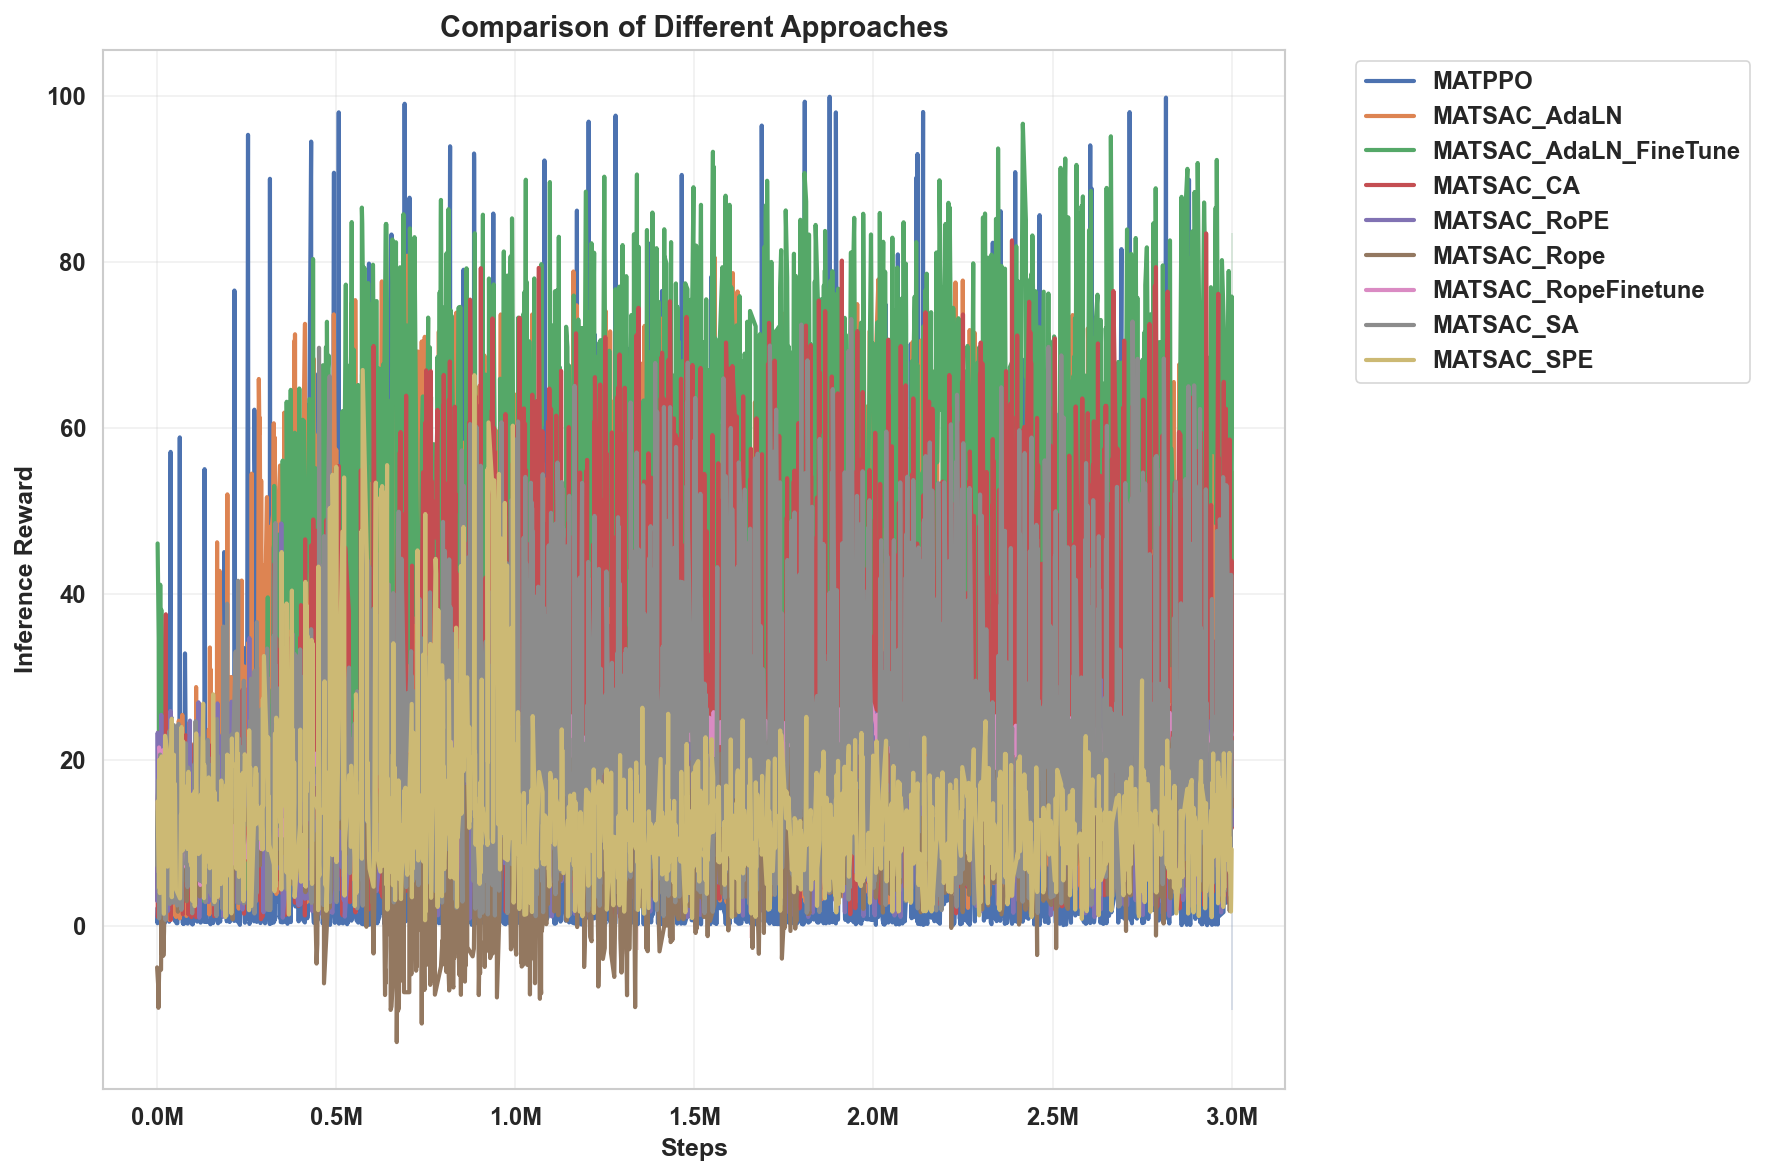

/tmp/ipykernel_2008557/2021820962.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['{:.1f}M'.format(x/1e6) for x in current_values])


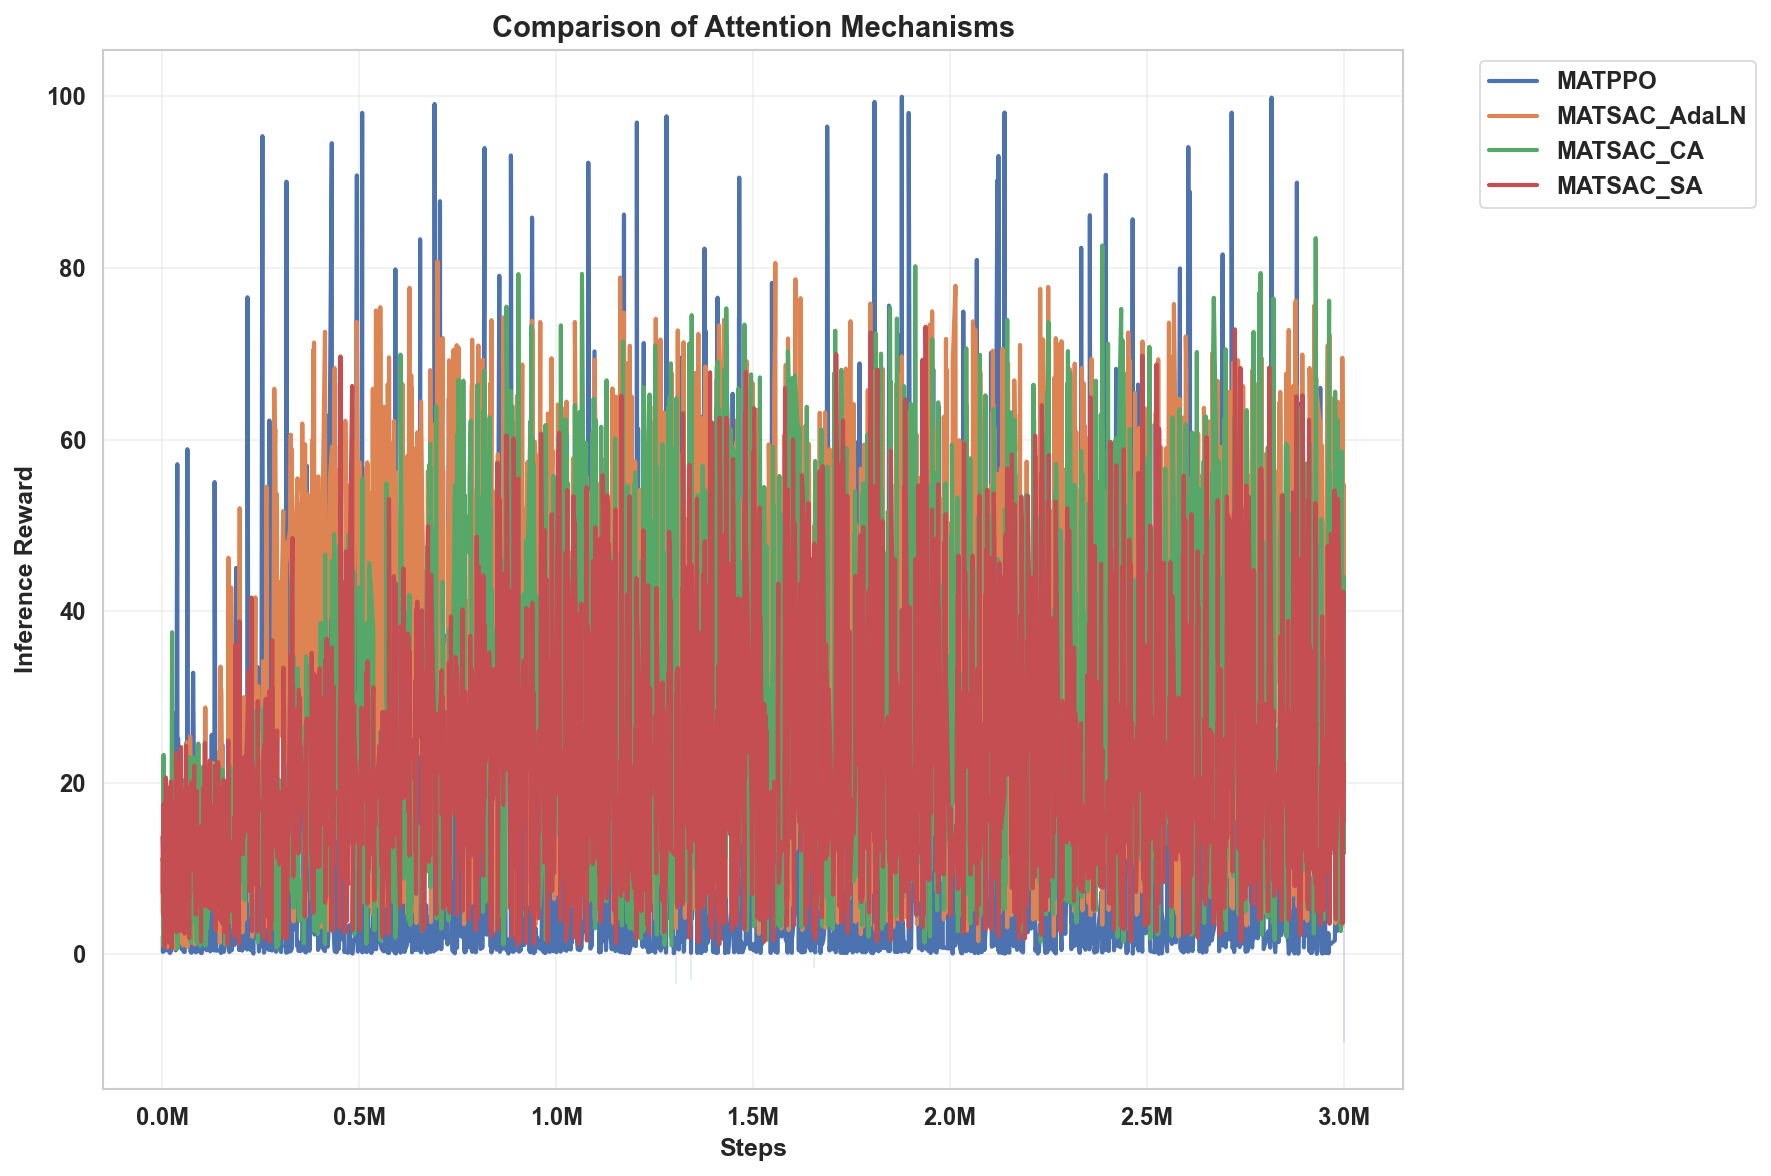

/tmp/ipykernel_2008557/2021820962.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['{:.1f}M'.format(x/1e6) for x in current_values])


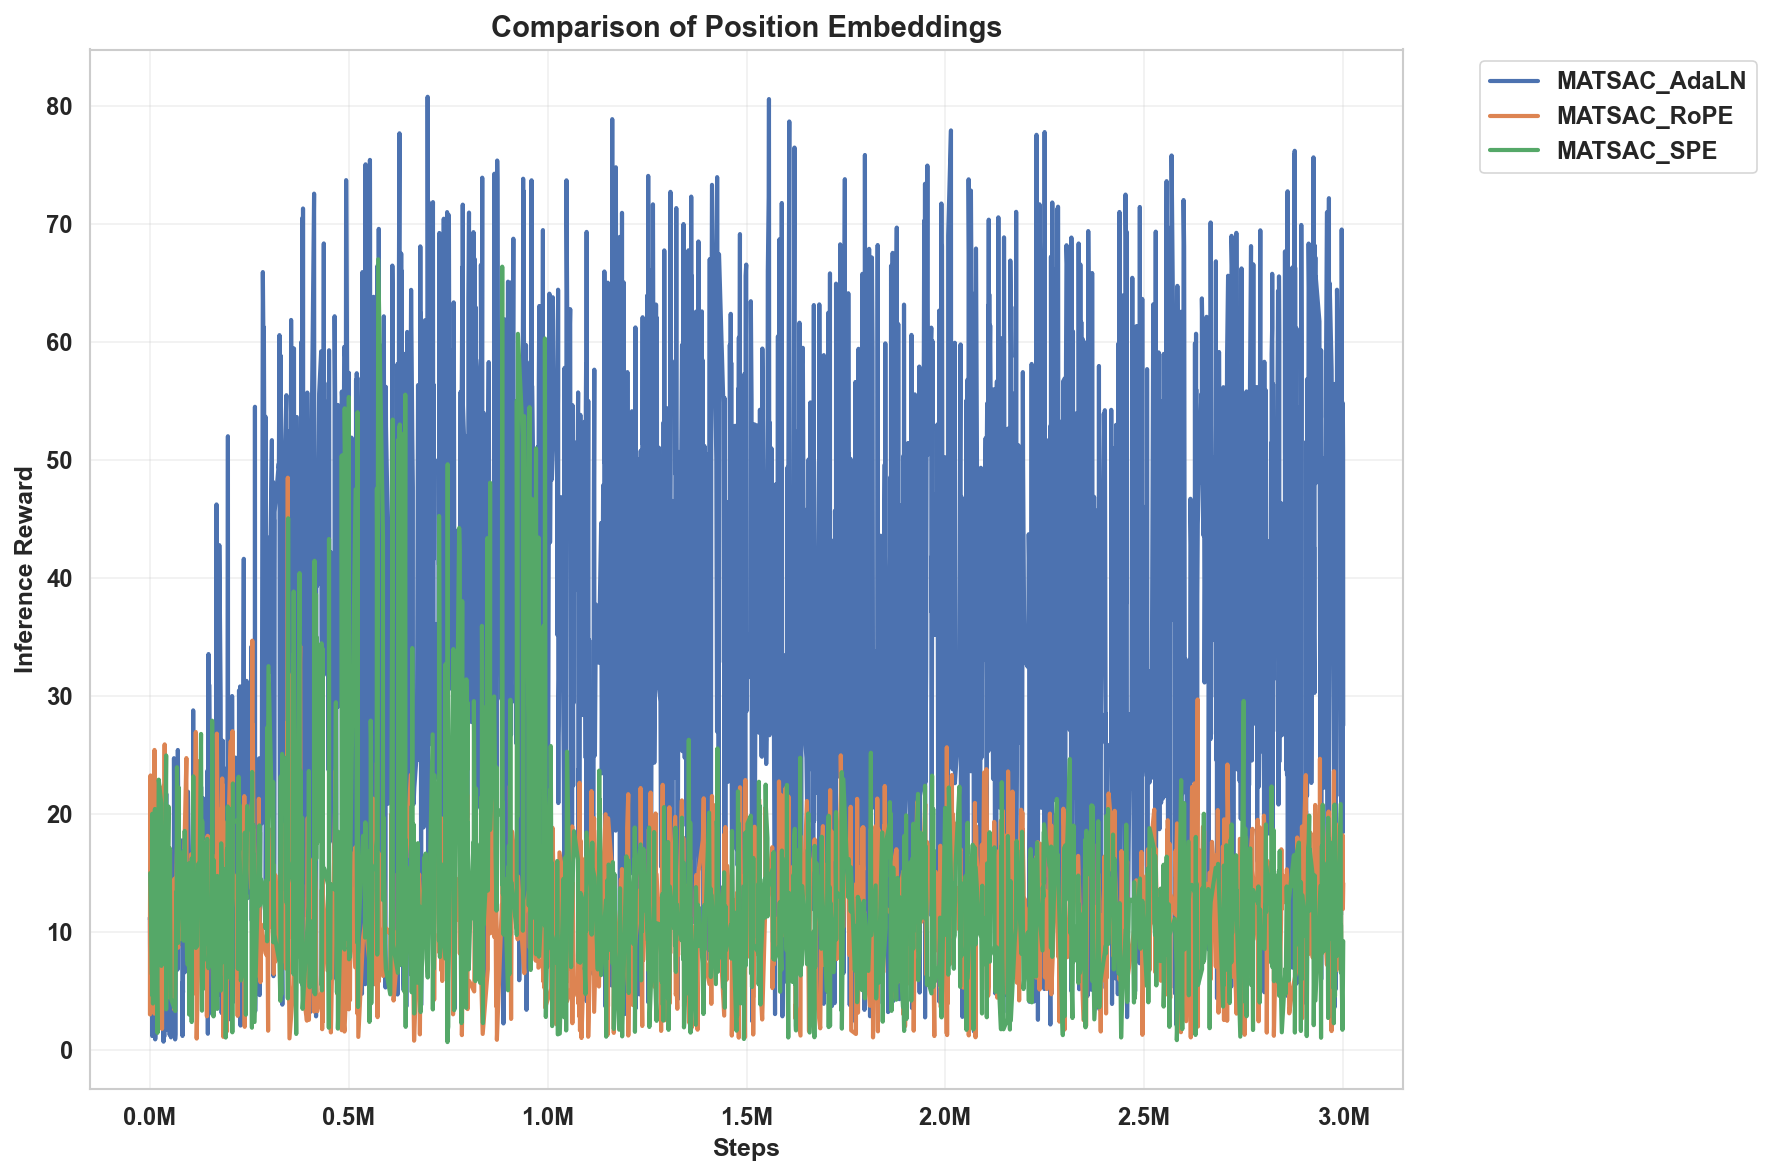

/tmp/ipykernel_2008557/2021820962.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['{:.1f}M'.format(x/1e6) for x in current_values])


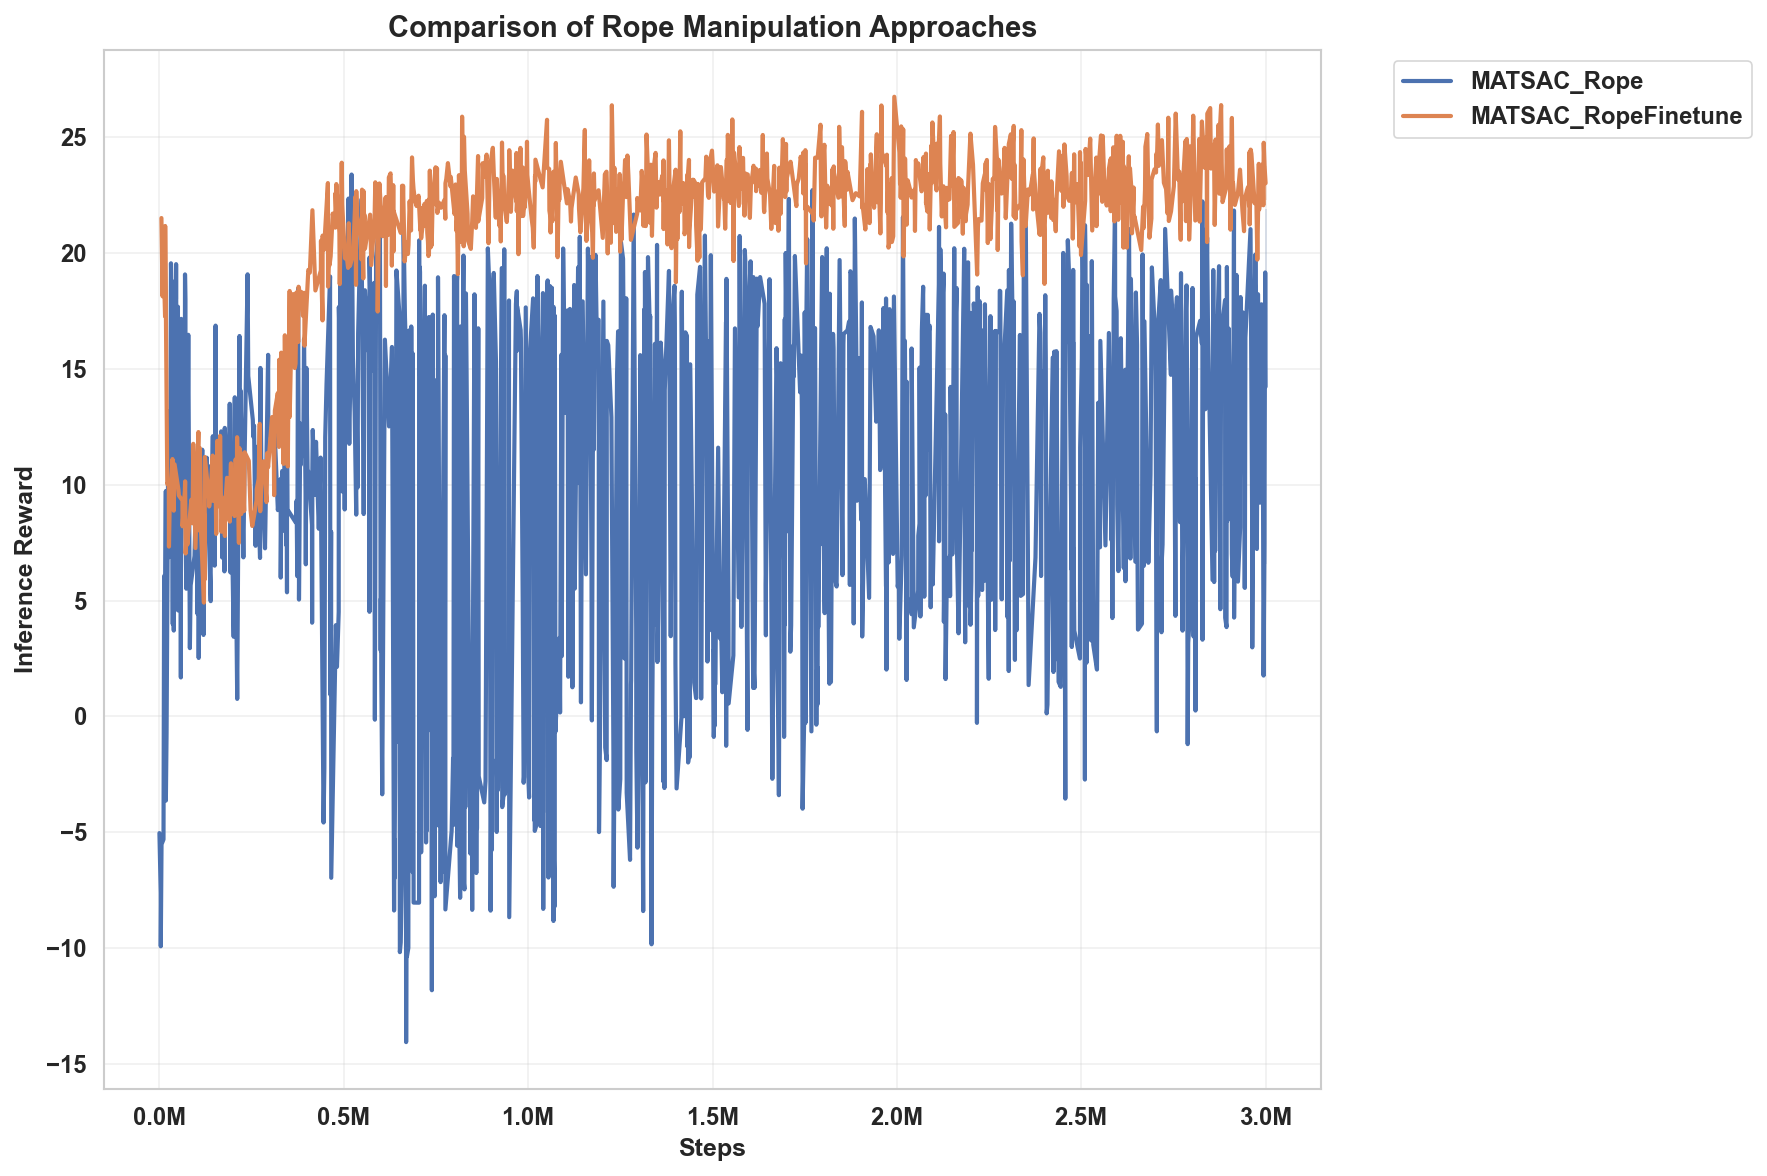

In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def scale_steps(master_df, target_steps=3_000_000):
    """
    Scale the _step values to span from 0 to target_steps while preserving relative spacing.
    """
    processed_data = []
    
    # Process each category and run combination
    for category in master_df['category'].unique():
        category_data = master_df[master_df['category'] == category]
        
        for run_name in category_data['run_name'].unique():
            run_data = category_data[category_data['run_name'] == run_name].copy()
            
            # Sort by steps
            run_data = run_data.sort_values('_step')
            
            # Calculate scaling factor
            max_step = run_data['_step'].max()
            scaling_factor = target_steps / max_step
            
            # Scale the steps
            run_data['_step'] = run_data['_step'] * scaling_factor
            
            processed_data.append(run_data)
    
    return pd.concat(processed_data, ignore_index=True)

def plot_results(processed_df, title="Training Progress", figsize=(12, 8)):
    """
    Create a plot showing the mean and standard deviation for each category.
    """
    plt.figure(figsize=figsize)
    
    # Set style
    sns.set_style("whitegrid")
    
    # Define a color palette
    palette = sns.color_palette("deep")
    
    # Plot each category
    for idx, category in enumerate(sorted(processed_df['category'].unique())):
        category_data = processed_df[processed_df['category'] == category]
        
        # Calculate mean and std for each unique step value
        stats = category_data.groupby('_step')['Inference Reward'].agg(['mean', 'std']).reset_index()
        
        # Plot mean line
        plt.plot(stats['_step'], stats['mean'], 
                label=category, 
                color=palette[idx],
                linewidth=2)
        
        # Plot confidence interval
        plt.fill_between(stats['_step'],
                        stats['mean'] - stats['std'],
                        stats['mean'] + stats['std'],
                        alpha=0.2,
                        color=palette[idx])
    
    plt.xlabel('Steps')
    plt.ylabel('Inference Reward')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Format x-axis to show millions
    current_values = plt.gca().get_xticks()
    plt.gca().set_xticklabels(['{:.1f}M'.format(x/1e6) for x in current_values])
    
    plt.tight_layout()
    return plt

# Process the data
processed_df = scale_steps(master_df)

# Create main comparison plot
plot_results(processed_df, "Comparison of Different Approaches")
plt.show()

# Create separate plots for different experiment groups
# Attention mechanism comparison
attention_df = processed_df[processed_df['category'].isin(['MATSAC_SA', 'MATSAC_CA', 'MATSAC_AdaLN', "MATPPO"])]
plot_results(attention_df, "Comparison of Attention Mechanisms")
plt.show()

# Position embedding comparison
embedding_df = processed_df[processed_df['category'].isin(['MATSAC_SPE', 'MATSAC_RoPE', 'MATSAC_AdaLN'])]
plot_results(embedding_df, "Comparison of Position Embeddings")
plt.show()

# Rope manipulation comparison
rope_df = processed_df[processed_df['category'].isin(['MATSAC_Rope', 'MATSAC_RopeFinetune'])]
plot_results(rope_df, "Comparison of Rope Manipulation Approaches")
plt.show()

In [30]:
processed_df.to_csv('../../data/test_traj/processed_df.csv', index=False)

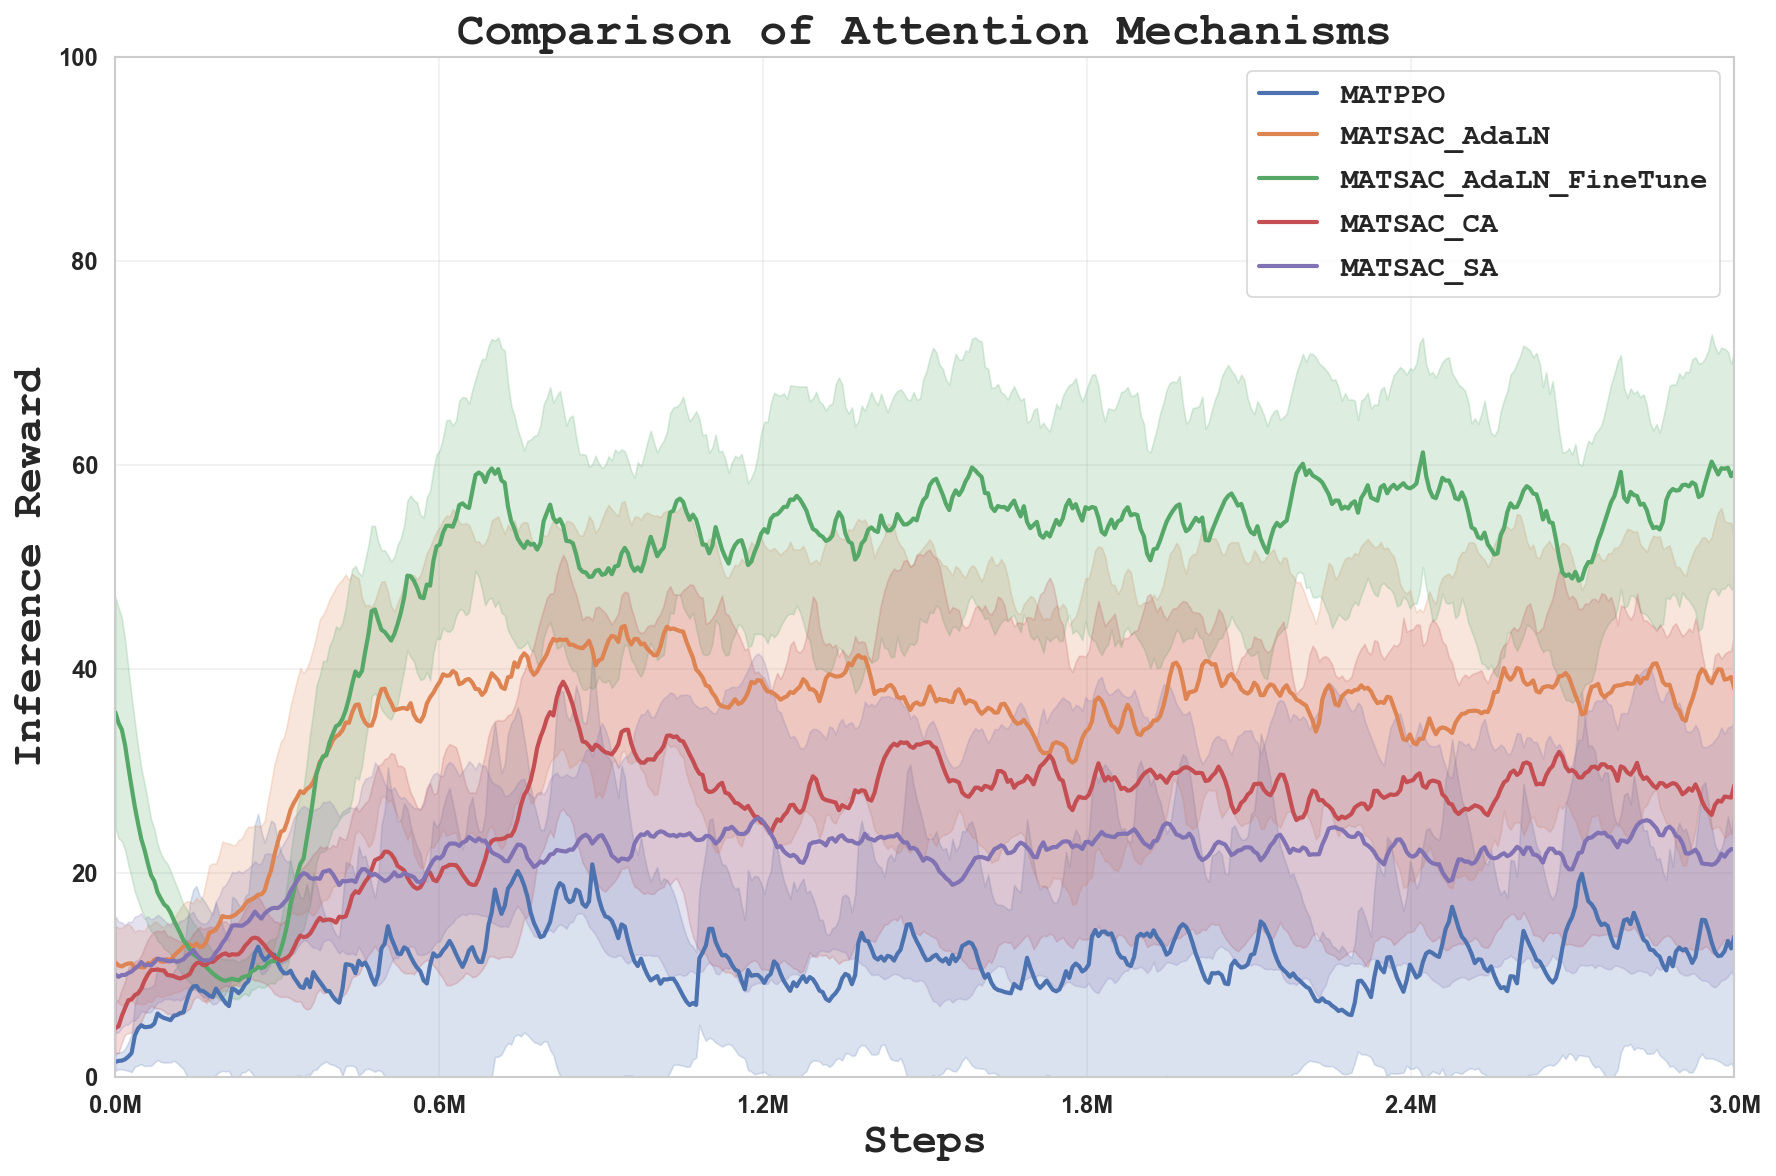

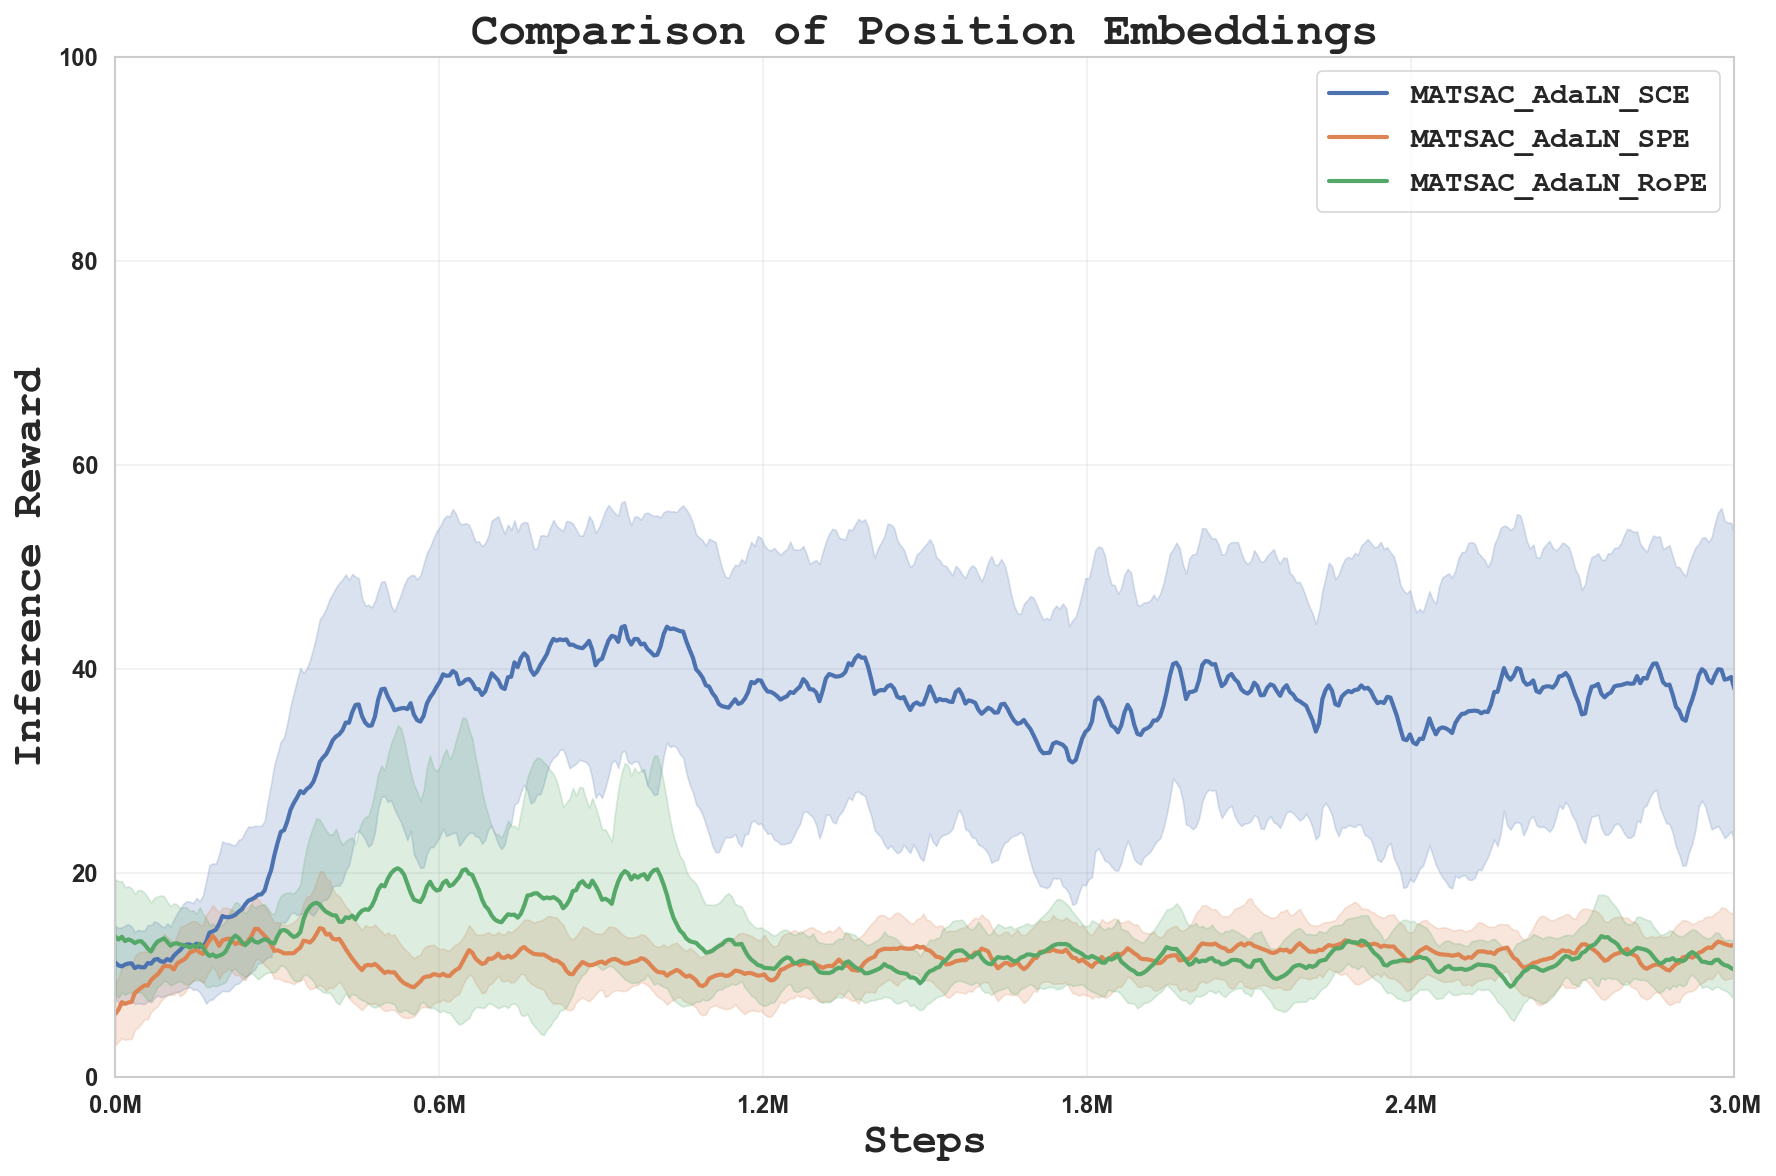

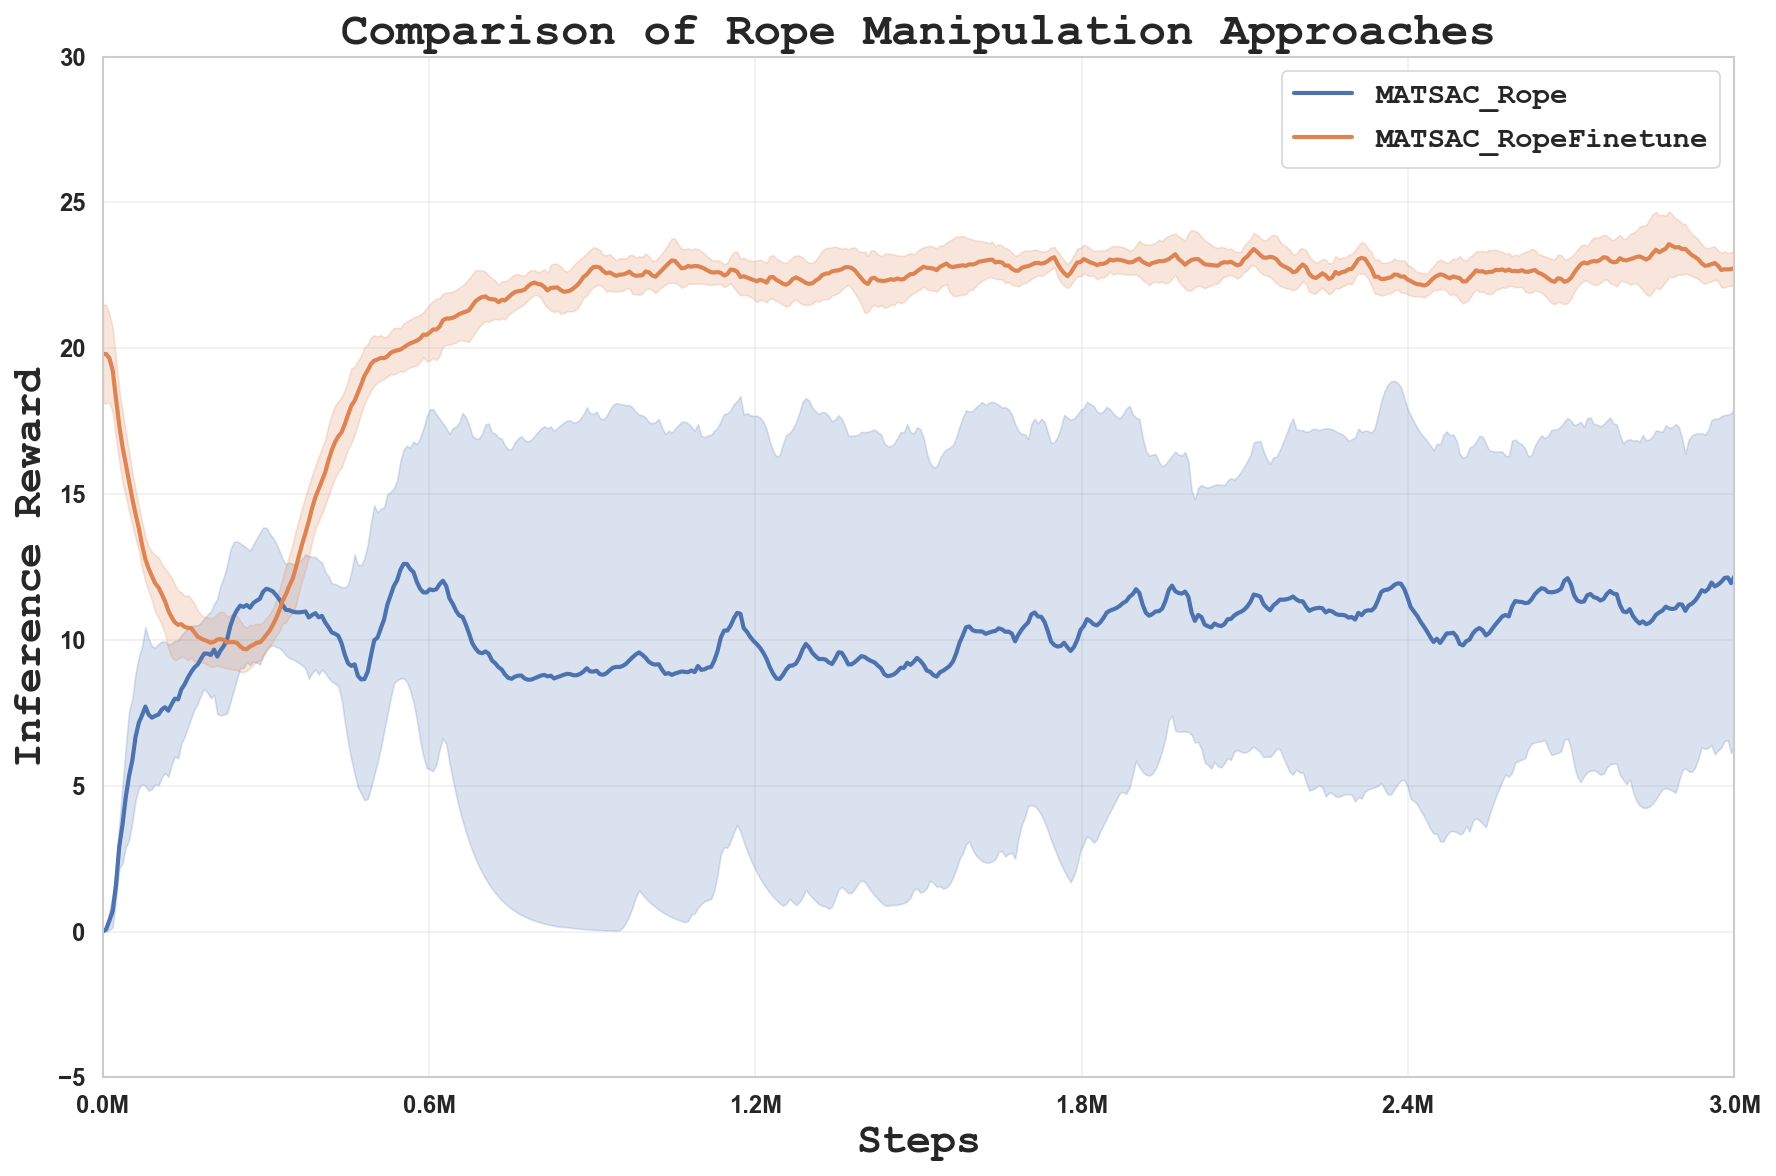

In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def compute_seed_statistics(processed_df, categories=None, num_points=500):
    """
    Compute statistics across seeds for specified categories with proper error handling.
    """
    if categories is None:
        categories = sorted(processed_df['category'].unique())
    else:
        # Verify all requested categories exist in the data
        existing_categories = set(processed_df['category'].unique())
        for cat in categories:
            if cat not in existing_categories:
                print(f"Warning: Category {cat} not found in data!")
                categories.remove(cat)
    
    # Initialize storage for results
    category_stats = {}
    
    # Create uniform step values
    min_step = processed_df['_step'].min()
    max_step = processed_df['_step'].max()
    uniform_steps = np.linspace(min_step, max_step, num_points)
    
    for category in categories:
        category_data = processed_df[processed_df['category'] == category]
        
        if len(category_data) == 0:
            continue
            
        # Storage for seed means
        seed_means = []
        
        # 1. Calculate mean for each seed
        for run_name in category_data['run_name'].unique():
            run_data = category_data[category_data['run_name'] == run_name]
            
            if len(run_data) < 2:  # Need at least 2 points for interpolation
                continue
                
            # Sort by steps
            run_data = run_data.sort_values('_step')
            
            # Ensure rewards are non-negative
            rewards = np.maximum(run_data['Inference Reward'].values, 0)
            
            try:
                # Interpolate to uniform steps
                f = interp1d(run_data['_step'].values, 
                           rewards,
                           kind='linear',
                           bounds_error=False,
                           fill_value=(rewards[0], rewards[-1]))  # Use endpoint values for extrapolation
                
                resampled_values = f(uniform_steps)
                # Ensure no negative values after interpolation
                resampled_values = np.maximum(resampled_values, 0)
                seed_means.append(resampled_values)
            except Exception as e:
                print(f"Warning: Interpolation failed for {category} - {run_name}: {str(e)}")
                continue
        
        if not seed_means:  # Skip if no valid data
            print(f"Warning: No valid data for category {category}")
            continue
            
        # Convert to numpy array for easier computation
        seed_means = np.array(seed_means)

        def ema_smooth(x, alpha=0.2):
            """Exponential Moving Average smoothing"""
            smoothed = np.zeros_like(x)
            smoothed[0] = x[0]
            for i in range(1, len(x)):
                smoothed[i] = alpha * x[i] + (1 - alpha) * smoothed[i-1]
            return smoothed

        def gaussian_smooth(x, sigma=2):
            """Gaussian smoothing"""
            window = int(6 * sigma)
            if window % 2 == 0:
                window += 1
            if window > len(x):
                window = len(x)
                if window % 2 == 0:
                    window -= 1
            return pd.Series(x).rolling(window=window, center=True, min_periods=1).mean().values

        # 2. Calculate meta-statistics across seeds
        meta_mean = np.nanmean(seed_means, axis=0)
        meta_std = np.nanstd(seed_means, axis=0)
        
        # Apply smoothing to both mean and std
        # Using EMA as it's common in RL papers
        smoothed_mean = ema_smooth(meta_mean, alpha=0.1)
        smoothed_std = ema_smooth(meta_std, alpha=0.1)
        
        # Alternative: Use Gaussian smoothing
        # smoothed_mean = gaussian_smooth(meta_mean, sigma=2)
        # smoothed_std = gaussian_smooth(meta_std, sigma=2)
        
        # Store results
        category_stats[category] = {
            'steps': uniform_steps,
            'mean': smoothed_mean,
            'std': smoothed_std
        }
    
    return category_stats

def plot_statistical_comparison(category_stats, title, pos_embed, figsize=(12, 8)):
    """
    Create a plot showing the meta-mean and meta-std for each category.
    """
    if pos_embed:
        names = ["MATSAC_AdaLN_SCE", "MATSAC_AdaLN_SPE", "MATSAC_AdaLN_RoPE"]
    
    if not category_stats:
        print("No valid data to plot!")
        return None
        
    plt.figure(figsize=figsize)
    
    plt.rcParams['font.family'] = 'Courier New'  # Set font family
    plt.rcParams['font.weight'] = 'bold'        # Set font weight to bold
    # Set style
    sns.set_style("whitegrid")
    plt.grid(True, alpha=0.3)
    
    # Define a color palette
    palette = sns.color_palette("deep")
    
    # Plot each category
    for idx, (category, stats) in enumerate(sorted(category_stats.items())):
        if np.all(np.isnan(stats['mean'])) or np.all(np.isnan(stats['std'])):
            print(f"Warning: Invalid statistics for {category}")
            continue
            
        # Plot mean line
        plt.plot(stats['steps'], stats['mean'], 
                label=names[idx] if pos_embed else category, 
                color=palette[idx], 
                linewidth=2)
        
        # Plot confidence interval
        plt.fill_between(stats['steps'],
                        np.maximum(stats['mean'] - stats['std'], 0),  # Ensure non-negative
                        stats['mean'] + stats['std'],
                        alpha=0.2,
                        color=palette[idx])
    
    big_soize = 20
    plt.xlabel('Steps', fontfamily='Courier New', fontweight='bold', fontsize=big_soize)
    plt.ylabel('Inference Reward', fontfamily='Courier New', fontweight='bold', fontsize=big_soize)
    plt.title(title, fontfamily='Courier New', fontweight='bold', fontsize=big_soize+2)
    
    # Move legend outside
    plt.legend(prop={'family': 'Courier New', 'weight': 'bold', 'size': 14})
    
    plt.xlim(0, max(stats['steps']))
    if "Rope" not in category:
        plt.ylim(0, 100)
    else:
        plt.ylim(-5, 30)
    # Format x-axis to show millions
    plt.gca().set_xticks(np.linspace(min(plt.gca().get_xticks()), max(plt.gca().get_xticks()), 6))
    plt.gca().set_xticklabels(['{:.1f}M'.format(x/1e6) for x in plt.gca().get_xticks()])
    
    plt.tight_layout()
    return plt

def create_comparison_plot(processed_df, categories, title, pos_embed=False):
    """
    Create a statistical comparison plot for specified categories.
    """
    # Compute statistics
    stats = compute_seed_statistics(processed_df, categories)
    
    # Create plot only if we have valid stats
    if stats:
        plot_statistical_comparison(stats, title, pos_embed)
        plt.show()

# Example usage:
try:
    # Attention mechanism comparison
    create_comparison_plot(
        processed_df,
        ['MATSAC_SA', 'MATSAC_CA', 'MATSAC_AdaLN', "MATSAC_AdaLN_FineTune", "MATPPO"],
        "Comparison of Attention Mechanisms"
    )

    # Position embedding comparison
    create_comparison_plot(
        processed_df,
        ['MATSAC_SPE', 'MATSAC_RoPE', 'MATSAC_AdaLN'],
        "Comparison of Position Embeddings",
        pos_embed=True
    )

    # Rope manipulation comparison
    create_comparison_plot(
        processed_df,
        ['MATSAC_Rope', 'MATSAC_RopeFinetune'],
        "Comparison of Rope Manipulation Approaches"
    )
except Exception as e:
    print(f"Error during plotting: {str(e)}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

def create_publication_plot(data_dict, task_names, method_names, colors=None, 
                          smooth_sigma=2, figsize=(15, 4)):
    """
    Create publication-quality comparison plots for multiple tasks.
    
    Args:
        data_dict: Dictionary of dictionaries with structure:
            {task_name: {method_name: {'steps': [...], 'mean': [...], 'std': [...]}}}
        task_names: List of task names to plot
        method_names: List of method names to compare
        colors: Dictionary mapping method names to colors
        smooth_sigma: Smoothing factor for the curves
        figsize: Figure size (width, height)
    """
    if colors is None:
        colors = {
            method_names[0]: '#7B68EE',  # Medium slate blue
            method_names[1]: '#FF4136'    # Red
        }
    
    # Set style
    plt.style.use('seaborn-white')
    
    # Create figure and gridspec
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, len(task_names), figure=fig)
    gs.update(wspace=0.3)
    
    # Create one subplot for each task
    for idx, task in enumerate(task_names):
        ax = fig.add_subplot(gs[0, idx])
        
        # Plot each method
        for method in method_names:
            data = data_dict[task][method]
            steps = data['steps']
            mean = data['mean']
            std = data['std']
            
            # Smooth the mean and std
            smooth_mean = gaussian_filter1d(mean, sigma=smooth_sigma)
            smooth_std = gaussian_filter1d(std, sigma=smooth_sigma)
            
            # Plot mean line
            line_style = '--' if method == method_names[1] else '-'
            ax.plot(steps, smooth_mean, line_style, 
                   color=colors[method], 
                   linewidth=2, 
                   label=method)
            
            # Plot confidence intervals
            ax.fill_between(steps, 
                          smooth_mean - smooth_std,
                          smooth_mean + smooth_std,
                          color=colors[method],
                          alpha=0.2)
        
        # Customize subplot
        ax.grid(True, alpha=0.3)
        ax.set_title(task, pad=10, fontsize=12)
        
        # Format x-axis to show millions
        ax.set_xlabel('Steps', fontsize=10)
        xticks = ax.get_xticks()
        ax.set_xticklabels([f'{int(x/1e6)}' for x in xticks])
        ax.set_xlabel(r'$\times 10^6$', fontsize=10)
        
        # Only show y-label for first subplot
        if idx == 0:
            ax.set_ylabel('Cumulative Reward', fontsize=10)
        
        # Show legend only in first subplot
        if idx == 0:
            ax.legend(loc='lower right', frameon=True, 
                     framealpha=0.9, edgecolor='none')
        
        # Set background color
        ax.set_facecolor('white')
    
    plt.tight_layout()
    return fig

# Example usage:
# Assuming you have your data in the correct format, you would use it like this:
"""
# Example data structure
data = {
    'HumanoidBench[Stand]': {
        'MaxInfoSAC': {
            'steps': np.linspace(0, 5e6, 1000),
            'mean': ...,
            'std': ...
        },
        'SAC': {
            'steps': np.linspace(0, 5e6, 1000),
            'mean': ...,
            'std': ...
        }
    },
    'HumanoidBench[Walk]': {
        # Similar structure
    },
    'HumanoidBench[Run]': {
        # Similar structure
    }
}

task_names = ['HumanoidBench[Stand]', 'HumanoidBench[Walk]', 'HumanoidBench[Run]']
method_names = ['MaxInfoSAC', 'SAC']

fig = create_publication_plot(data, task_names, method_names)
plt.savefig('comparison_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()
"""

def smooth_data(data, sigma=2):
    """
    Apply Gaussian smoothing to data.
    """
    return gaussian_filter1d(data, sigma=sigma)

def prepare_plot_data(processed_df, categories, task_names, smooth_sigma=2):
    """
    Prepare data in the format needed for publication plotting.
    """
    plot_data = {}
    
    for task in task_names:
        plot_data[task] = {}
        for category in categories:
            stats = compute_seed_statistics(processed_df[processed_df['task'] == task], 
                                         [category])
            if category in stats:
                plot_data[task][category] = {
                    'steps': stats[category]['steps'],
                    'mean': smooth_data(stats[category]['mean'], smooth_sigma),
                    'std': smooth_data(stats[category]['std'], smooth_sigma)
                }
    
    return plot_data